# Optimization of Fuzzy Logic Controller Used for a Differential Drive Wheeled Mobile Robot

This notebook contains a set of experiments with fuzzy logic controller optimization. The fuzzy logic controller is designed for robot control.

In [ ]:
_runDemos = True # this is queried in this document later multiple times

## Cluster Query

This task could use for its solution a computer cluster. As it is optional, use it only when you are running it. In this case you must set the option ```useCluster``` to ```True``` and set proper value in ```url``` variable.

In [ ]:
useCluster = False
url = 'http://192.168.1.100:4000/api/evaluator/FFFF'

In [ ]:
Waypoint = True
Number8 = False
Circle = False

## Inevitable Imports

Fuzzy operations are computed with use of [scikit-fuzzy library](https://github.com/scikit-fuzzy/scikit-fuzzy).

In [ ]:
!pip install scikit-fuzzy

In [ ]:
import numpy as np
import math
import random
from math import *
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd
import skfuzzy as fuzz

In [ ]:
%matplotlib inline

With this %matplotlib inline, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

## Robot parameters

In [ ]:
robotState0 = {
    'x': 0,
    'y': 0,
    'theta': 0
}

robotParams = {
    'r': 0.0425,    #meter
    'b': 0.2,       #meter
    'm': 1.733,     #Kg
    'I': 0.08,  #Kg.m2
}

## Robot models

### Kinematic model

In [ ]:
from math import sin, cos
def createRobot(params):
    m = params['m']
    I = params['I']

    def robot(t, currentState, controller):
        # ask controller for velocity and omega
        velocity, omega = controller(t, currentState)

        currentTheta = currentState[2]
        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)

        x_dot = velocity * cosTheta
        y_dot = velocity * sinTheta
        theta_dot = omega

        E = 0.5 * (m * velocity * velocity + I * omega * omega)

        return [x_dot, y_dot, theta_dot, velocity, omega, E] # velocity, omega, E are returned for easy evaluation they are not needed for computation
    return robot

robot = createRobot(robotParams)

### Dynamic Model

The dynamic model extends the kinematic model with differential equations describing the motors.

In [ ]:
# example of motor parameters,
motorParams = {
    'J': 0.037,       #Kg.m2/s2
    'B': 0.004,        #Nms
    
    'Kt': 0.16,    #Nm/A
    'Ke': 0.9965,    #Nm/A
        
    'Ra': 0.37,    #Ohm
    'La': 0.1   #H
}

#//////////////////////////////////////////////////////////////////////////////
def createFilter2ndOrder(b1, b0, a1, a0):
    def filter2ndOrder(t, u, currentState):
        x0 = currentState[0]
        x1 = currentState[1]
        dx0 = b0 * u + a0 * x0 + x1
        dx1 = b1 * u + a1 * x0
        return [dx0, dx1]
    return filter2ndOrder

def createMotorModel(motorParams=None):
    if motorParams is None:
        return None
    
    Kt = motorParams['Kt']
    Ke = motorParams['Ke']
    J = motorParams['J']
    La = motorParams['La']
    Ra = motorParams['Ra']
    B = motorParams['B']
    # Motor+Chassis Dynamics equivalent to F(s)=(0.7607s+17.62)/(s2+9.568s+12.07)
    b1 = 9396 #Kt / (La * J)
    b0 = 0
    a1 = -9449 #-(Ra * B + Kt * Ke) / (La * J)
    a0 = -689.6 #-(Ra * J + La ) / (La * J)
    return createFilter2ndOrder(b1, b0, a1, a0)
    

def createRobotModelWithDynamic(params, motorModel = None):
    """
    function returns standard ODE model usable in many libraries (scipy)
    """
    m = params['m']
    I = params['I']
    b = params['b']

    motorAsFilter = motorModel
    def robotWithDynamic(t, currentState, controller):
        # ask controller for velocity and omega
        velocity, omega = controller(t, currentState)

        delta = omega * b / 2
        vL = velocity - delta
        vR = velocity + delta
        vLState = currentState[6:8]
        vRState = currentState[8:10]
        vLStateD = motorAsFilter(t, vL, vLState)
        vRStateD = motorAsFilter(t, vR, vRState)
        vLFiltered = vLState[0]
        vRFiltered = vRState[0]

        velocity = (vRFiltered + vLFiltered) / 2
        delta = (vRFiltered - vLFiltered) / 2
        omega = 2 * delta / b

        currentTheta = currentState[2]
        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)

        x_dot = velocity * cosTheta
        y_dot = velocity * sinTheta
        theta_dot = omega

        E = 0.5*(m*(velocity)*(velocity) + I*(omega)*(omega))

        return [x_dot, y_dot, theta_dot, velocity, omega, E, *vLStateD, *vRStateD] #velocity, omega, E are returned for easy evaluation they are not needed for computation

    def robot(t, currentState, controller):
        """
        This closure is result of parent function
        """
        # ask controller for velocity and omega
        velocity, omega = controller(t, currentState)

        currentTheta = currentState[2]
        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)

        x_dot = velocity * cosTheta
        y_dot = velocity * sinTheta
        theta_dot = omega

        E = 0.5 * (m * velocity * velocity + I * omega * omega)

        return [x_dot, y_dot, theta_dot, velocity, omega, E] #velocity, omega, E are returned for easy evaluation they are not needed for computation

    if motorModel is None:
        return robot
    else:
        return robotWithDynamic
    pass
  
motorModel = createMotorModel(motorParams)    
robotWithDynamic = createRobotModelWithDynamic(robotParams, motorModel)
robot = robotWithDynamic # If you delete / comment this line, only the Kinematic model is taken into account.

## Solver

### Selectors

Selectors are named functions which have been designed for selecting appropriate part of simulation results. They can simplify a data capture or a data analysis in or after simulation.

In [ ]:
# selectors are defined for extration of data from results computed by ODE solver
selectx = lambda item: item['y'][0]       # x position
selecty = lambda item: item['y'][1]       # y position
selectt = lambda item: item['time']       # time
selectv = lambda item: item['dy'][3]      # velocity
selectomega = lambda item: item['dy'][2]  # omega = theta_dot
selecte = lambda item: item['TotalEnergy']# total energy
selects = lambda item: item['y'][3]       # displacement
selectors = {
    'time': selectt,
    'x': selectx, 
    'y': selecty, 
    'd': selects, 
    'v': selectv, 
    'omega': selectomega,
    'E': selecte}

### Solver Function

The next function is designed as a generator and thus it performs one simulation step and returns a single simulation state when it is asked. Such design allows to have infinite loop inside this function. Theory about generators could be studied [here](https://wiki.python.org/moin/Generators).

In [ ]:
def compute(model, state0, t0 = 0.0, t_bound = 10, max_step = 0.01):
    """
    This function returns a generator containing the sequence of resuls. 
    In this particular case it will return a sequence of robot states.
    """
    solver = integrate.RK45(fun = model, t0 = t0, y0 = state0, t_bound = t_bound, max_step = max_step)
    cnt = 0
    lastEnergy = 0
    totalEnergy = 0

    while True:
        message = solver.step()
        currentItem = {'time': solver.t, 'y': solver.y, 'dy': model(solver.t, solver.y)}
        
        ###################################################
        # Energy calculation / energy sumation
        currentEnergy = currentItem['dy'][5] 
        deltaEnergy = currentEnergy - lastEnergy

        if deltaEnergy > 0:
            totalEnergy = totalEnergy + deltaEnergy
        lastEnergy = currentEnergy
        currentItem['TotalEnergy'] = totalEnergy
        ###################################################

        yield currentItem
        if (not(solver.status == 'running')):
            break
    return

## Path Controller

Path Controller transforms a controller navigating robot towards a fixed distance to the controller able switch the destination immediately after reaching point defined by a given path.

In [ ]:

def controllerForPath(controller, path, distanceEps = 0.01): 
    destinationX, destinationY, destinationOrietation = next(path)
    destinationState = [destinationX, destinationY, destinationOrietation]
    lastReached = False
    #print('Destination set to', destinationState)
    def result(t, currentState):
        """
        This closure is result of parent function and acts as a controller - mediator,
        which commands the given controller.
        """
        nonlocal destinationX # use parent variable
        nonlocal destinationY # use parent variable
        nonlocal destinationState # use parent variable
        nonlocal lastReached # use parent variable

        currentX = currentState[0]
        currentY = currentState[1]
        deltaX = destinationX - currentX
        deltaY = destinationY - currentY
        if (lastReached == False):
          # last point in path was not reached
          if (deltaX * deltaX + deltaY * deltaY < distanceEps):
            # robot is close enought to currentDestination
            try:
                # try to get another point on path
                destinationX, destinationY, destinationOrietation = next(path)
                destinationState = [destinationX, destinationY, destinationOrietation]
                #print('Destination set to', destinationState, 'while in state', currentState)
            except StopIteration:
              # there are no other points
              lastReached = True
        if (lastReached):
            return (0, 0)
        else:
            return controller(t, currentState, destinationState)
    return result


## Model Creator

Model creator is function which packs all subsystems into one described by standard ODE function. Standard methods for ODE problems could be applied on such result / function. Standard use are granted by the signature
```python
def func(time, state)
```
Such signature has a function returned by ```robotModelCreator```.

In [ ]:
def robotModelCreator(controllerCreator, path, **kwargs):
    controller_ = controllerCreator(**kwargs)
    savedController = controllerForPath(controller_, path)
    def resultRMC(t, currentState):
        return robot(t, currentState, savedController)
    return resultRMC

## Computation

Simple compute allows to fully define parameters at first and then use it on model. Such approach is usefull in case when different models (controllers) are used for same task. In this case this function simplify comparison of different controllers.

In [ ]:
def simpleCompute(computefunc, state0, t0 = 0, t_bound = 200, max_step = 0.01):
    def resultSC(model):
        return computefunc(
          model, state0 = state0, t0 = t0, t_bound = t_bound, max_step = max_step)
    return resultSC

## Controllers

All controllers have to have same signature (parameter list)

```python
def controller(t, currentState, destinationState)
```

thus a creator taking special controller parameters must be defined. Such a creator should accept all special parameters and return controller with standard signature.

### Circle Controller

The Circle-based controller has been introduced and improved by Prof. Alexandr Štefek in [18] of this paper. (A. Stefek, V. Krivanek, Y. Bergeon, J. Motsch, “Differential Drive Robot: Spline-Based Design of Circular Path”. Awrejcewicz J. (eds) Dynamical Systems: Theoretical and Experimental Analysis. Springer Proceedings in Mathematics & Statistics, vol 182. Springer, Cham, 2016, pp 331-342.)

A brief of this controller as below:

$v=\frac{v_r+v_l}{2}$

$\Delta=\frac{v_r-v_l}{2}$

$R=\frac{v b}{2 \Delta}$

$\omega=\frac{2 \Delta}{b}$

$\dot x=v \cdot cos(\theta)$

$\dot y=v \cdot sin(\theta)$

$\dot \theta=\omega$

$\omega=-2\cdot k_1\cdot v\cdot \frac{\Delta X\cdot sin(\theta) - \Delta Y\cdot cos(\theta)}{(\Delta X)^2 + (\Delta Y)^2}$

Where:

 $k_1 > 0$ : is a coefficient of controller.
 For this simulation we use $v = v_{ri}$ is reference linear velocity of the robot

In [ ]:
def createCircleControllerWithGain(gain, omega_ri, vri, lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
    def controller(t, currentState, destinationState):
        currentX = currentState[0]
        currentY = currentState[1]
        currentTheta = currentState[2]

        destinationX = destinationState[0]
        destinationY = destinationState[1]

        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)

        deltaX = destinationX - currentX
        deltaY = destinationY - currentY

        velocity = vri
        omega = -2 * gain * vri * (deltaX * sinTheta - deltaY * cosTheta) / (deltaX * deltaX + deltaY * deltaY)
    
        if (velocity > highVelocityLimit):
            velocity = highVelocityLimit
        if (velocity < lowVelocityLimit):
            velocity = lowVelocityLimit
        if (omega > highOmegaLimit):
            omega = highOmegaLimit
        if (omega < lowOmegaLimit):
            omega = lowOmegaLimit

        return velocity, omega
    return controller

#### Full Example of Use

This part demonstrate the ide of code structure. There is the full run of simulation described by a set of functions.

In [ ]:

def localDemo():
    pathForSimulation = iter([
            [0, 0, 0],  #X, Y, orientation
            [10, 0, 0], #X, Y, orientation
            [10, 10, 0], #X, Y, orientation
            [20, 10, 0], #X, Y, orientation
            [20, 20, 0]
        ])

    robotState0 = {
            'x': 0,
            'y': 0,
            'theta': -3.14 / 4
        }

    t0 = 0
    t_bound = 100
    max_step = 0.01

    state0 = None
    if robot == robotWithDynamic:
        state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
    else:
        state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

    solverfunc = simpleCompute(
        compute, state0 = state0, 
        t0 = t0, t_bound = t_bound, max_step = max_step)    

    controllerParams = {
        'gain': 4, 
        'omega_ri': 0, 
        'vri': 2.0, 
        'lowVelocityLimit': 0, 
        'highVelocityLimit': 4.0, 
        'lowOmegaLimit': -3.14, 
        'highOmegaLimit': 3.14
        }

    fullRobot = robotModelCreator(createCircleControllerWithGain, pathForSimulation, **controllerParams)      
    state1 = fullRobot(0, state0)
    robotStates = solverfunc(fullRobot)

    results = {}
    for key, selector in selectors.items():
        print(key)
        results[key] = []

    for currentState in robotStates: # readout all states from current moving robot
        for key, selector in selectors.items():
            results[key].append(selector(currentState))

    plt.plot(results['x'], results['y'])

if _runDemos:
    localDemo()


### Robins

The Robins Mathew based controller has introduced by Robins Mathew in [28]. (R. Mathew and S. S. Hiremath, “Development of Waypoint Tracking Controller for Differential Drive Mobile Robot,” in International Conference on Control, Decision and Information Technologies (CoDIT), Paris, France, 2019, pp. 1121-1126.)

A brief of the Robins Mathew Controller is as below:


$$ \begin{pmatrix}
v_{ci} \\
\omega_{ci}  
\end{pmatrix} = 
\begin{pmatrix}
v_{ri}\cdot cos\theta_{ie}\\
\omega_{ri} + k_1\cdot v_{ri}\cdot T_{ie} + k_2\cdot v_{ri}\cdot sin\theta_{ie} 
\end{pmatrix} $$

Where:

$v_{ci}$ : is the linear velocity of robot

$\omega_{ci}$ : is the angular velocity of robot

$v_{ri}$ : is the reference linear velocity of robot

$\omega_{ri}$ : is the reference angular velocity of robot

$\theta_{ie}$ = $\theta_{wk} - \theta_i$ : 

$\tan\theta_{ie} = \frac{y_{wk}-y_i}{x_{wk}-x_i}$   

$\theta_i$ is the orientation of robot

$k_1, k_2 > 0$ : are the control gains

$T_{ie} = sin\phi\cdot(x_i - x_{wk}) - cos\phi\cdot(y_i - y_{wk})$ : is the cross-track error

$\tan\phi = \frac{y_{wk}-y_{wk-1}}{x_{wk}-x_{wk-1}}$ the $\phi$ is defined as the angle made by the line
connecting current waypoint with the previous waypoint

$(x_i, y_i, \theta_i)$ : is the current robot position

$(x_{wk}, y_{wk}, \theta_{wk})$ : is the waypoint posture

In [ ]:
def createController_By_RobinsMathew(k0, k1, omega_ri, vri, lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
    def controller(t, currentState, destinationState):
        currentX = currentState[0]
        currentY = currentState[1]
        currentTheta = currentState[2]

        destinationX = destinationState[0]
        destinationY = destinationState[1]

        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)
    
        deltaX = destinationX - currentX
        deltaY = destinationY - currentY
        theta_destination = atan2(deltaY, deltaX)
        theta_error = theta_destination - currentTheta

        Te = math.sin(theta_destination)*deltaX - math.cos(theta_destination)*deltaY
    
        velocity = vri*math.cos(theta_error)
        omega = omega_ri + k0*vri*Te + k1*vri*math.sin(theta_error)

        if velocity > highVelocityLimit:
            velocity = highVelocityLimit
        if (velocity < lowVelocityLimit):
            velocity = lowVelocityLimit
        if omega > highOmegaLimit:
            omega = highOmegaLimit
        if (omega < lowOmegaLimit):
            omega = lowOmegaLimit
      
        return velocity, omega
    return controller

###  Chaudhari-based Controller

Chaudhari et al. have used Dubins path to smooth the optimal path (A*)

Dubins curve consists of several circular segments and straight segments. The shortest Dubins curve consists of three circular segments and straight segments. The primary forms are: (RSL, LSL, RSR, LSR, RLR, LRL). Where L, R represent the circular turning to the left and right respectively, S represent the tangent connecting two turning circulars [16].

The Dubins Path-based controller is expressed as below:

`minimal_radius = radius` is minimal rotation radius of the robot

`angle_epsilon = 0.05` is small positive value of the angle 

$v_{ri}$ is linear reference velocity of the robot

` angle_delta = currentTheta - angle_to_destination`

- If `angle_delta < - angle_epsilon`, then controller is

> $v = v_{ri}$; 
$\omega = \frac {v}{radius}$

- If `angle_delta > + angle_epsilon`, then controller is

> $v = v_{ri}$; 
$\omega = \frac {-v}{radius}$

- If `angle_delta = angle_epsilon`, then controller is

> $v = v_{ri}$; 
$\omega = 0$

In [ ]:
def createChaudhariController(radius, omega_ri, vri, lowVelocityLimit, highVelocityLimit,lowOmegaLimit, highOmegaLimit):
  minimal_radius = radius
  angle_epsilon = 0.05 # radians
  def controller(t, currentState, destinationState):
    currentX = currentState[0]
    currentY = currentState[1]
    currentTheta = currentState[2]
    
    # hacky, because it could be outside interval <-PI, +PI> :(
    while currentTheta < -2 * pi:
      currentTheta = currentTheta + 2 * pi
    while currentTheta > 2 * pi:
      currentTheta = currentTheta - 2 * pi

    destinationX = destinationState[0]
    destinationY = destinationState[1]

    deltaX = destinationX - currentX
    deltaY = destinationY - currentY

    angle_to_destination = atan2(deltaY, deltaX)

    #https://stackoverflow.com/questions/1878907/the-smallest-difference-between-2-angles

    angle_delta = currentTheta - angle_to_destination

    if (angle_delta > pi):
      angle_delta -= 2 * pi
    if (angle_delta < -pi):
      angle_delta += 2 * pi

    if (angle_delta < - angle_epsilon):
      # turn on minimal radius
      velocity = vri
      omega = velocity / minimal_radius
    elif (angle_delta > + angle_epsilon):
      # turn on minimal radius
      velocity = vri
      omega = -velocity / minimal_radius
    else:
      # go straight
      velocity = vri
      omega = 0

    if velocity > highVelocityLimit:
      velocity = highVelocityLimit
    if (velocity < lowVelocityLimit):
      velocity = lowVelocityLimit
    if omega > highOmegaLimit:
      omega = highOmegaLimit
    if (omega < lowOmegaLimit):
      omega = lowOmegaLimit

    return velocity, omega
  return controller

### Fuzzy Logic Controller

The Fuzzy Logic Controller (FLC) has been designed based on [2], [3], [4], [5] of this paper.

A brief of the FLC is described below:

A structure of a fuzzy logic controller is shown in figure below:

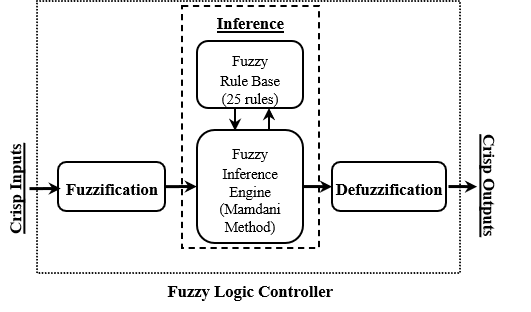

The FLC mainly contains three operations: the fuzzification, the inference, and the defuzzification.

This controller has 02 inputs and 02 outputs. 

**The 02 INPUTS:** DISTANCE_ERROR AND THETA_ERROR

- The "DISTANCE_ERROR" is the distance from the current position of the robot to the destination position of the destination. Its unit is meter (m), in this experiment I set it is in range $[0, 10]$.

- The "THETA_ERROR" is the different angle between the current orientation of the robot with the line of sight angle from current possition of the robot to the destination. Its unit is radian (rad), and its value is in range $[-\pi\ , \pi]$.

**The 02 OUTPUTS:** omega_R and omega_L

  + The omega_R is the angular velocity of the right wheel of the robot. Its unit is ($rads^{-1}$), in this experiment it is in range [0, 30]$rads^{-1}$.

  + The omega_L is the angular velocity of the left wheel of the robot. Its unit is ($rads^{-1}$), in this experiment it is in range [0, 30]$rads^{-1}$.

**FUZZIFICATION:** In this experiment the memberships have been presented as below:
 
  + Membership functions for the DISTANCE_ERROR is Triangular. The parameters of the input DISTANCE_ERROR are in the table I below:

  \begin{array}\hline
    \text{Table I:  DISTANCE_ERROR (m)}
  \end{array}
   \begin{array}{|c | c |c |c |}\hline
     \text{Name} & \text{Acronyms} & \text{Values}\\\hline
     Very Close   & VC     & [0, 0, 2.5]    \\\hline
     Close        & C      & [0, 2.5, 5]    \\\hline
     Medium       & M      & [2.5, 5, 7.5]    \\\hline
     Far          & F      & [5, 7.5, 10]    \\\hline
     Very Far     & VF     & [7.5, 10, 10]    \\\hline
  \end{array} 

   + Membership functions for the THETA_ERROR is Triangular. The parameters of the input THETA_ERROR are in the table Ii below:

  \begin{array}\hline\
    \text{Table iI:   THETA_ERROR (rad)}
  \end{array}
  \begin{array}{|c | c |c |c |}\hline    
     \text{Name} & \text{Acronyms} & \text{Values}\\\hline
     Big Negative   & BN     & [-3.14, -3.14, -1.57]   \\\hline
     Negative       & N      & [-3.14, -1.57, 0]       \\\hline
     Zero           & Z      & [-1.57, 0, 1.57]        \\\hline
     Positive       & P      & [0, 1.57, 3.14]         \\\hline
     Big Positive   & BP     & [1.57, 3.14, 3.14]      \\\hline
  \end{array} 


  + Membership functions for omega_R and omega_L  are Triangulars. The parameters of the output omega_R and omega_L are in the table III below:

  \begin{array}\hline
    \text{Table III:  omega_R, omega_L ($rads^{-1}$)}
  \end{array}
  \begin{array}{|c | c |c |c |}\hline
     \text{Name} & \text{Acronyms} & \text{Values}\\\hline
     Very Small   & VS     & [0, 0, 7.5]      \\\hline
     Small        & S      & [0, 7.5, 15]     \\\hline
     Medium Big   & MB      & [7.5, 15, 22.5]    \\\hline
     Big          & B      & [15, 22.5, 30]    \\\hline
     Very Big     & VB     & [22.5, 30, 30]    \\\hline
  \end{array} 

It can be expressed in the table IV below:

\begin{array}\hline
  \text{Table IV:  The rules for omega_R}
\end{array}
\begin{array}{|c | c |c |c |}\hline
     \text{ $\Delta D$ \ $\Delta \Theta$} & \text{ BN } & \text{ N } & \text{ Z } & \text{ P } & \text{ BP }\\\hline
     VC   & VSR     & SR    & VSR   & BR    & VBR   \\\hline
     C    & VSR     & SR    & SR    & BR    & VBR   \\\hline
     M    & VSR     & SR    & MBR   & BR    & VBR   \\\hline
     F    & VSR     & SR    & BR    & BR    & VBR   \\\hline
     VF   & VSR     & SR    & VBR   & BR    & VBR   \\\hline
\end{array} 

It can be expressed in the table V below:

\begin{array}\hline
  \text{Table V:  The rules for omega_L}
\end{array}
\begin{array}{|c | c |c |c |}\hline
     \text{ $\Delta D$ \ $\Delta \Theta$} & \text{ BN } & \text{ N } & \text{ Z } & \text{ P } & \text{ BP }\\\hline
     VC   & VBL     & BL    & VSL   & SL    & VSL   \\\hline
     C    & VBL     & BL    & SL    & SL    & VSL   \\\hline
     M    & VBL     & BL    & MBL   & SL    & VSL   \\\hline
     F    & VBL     & BL    & BL    & SL    & VSL   \\\hline
     VF   & VBL     & BL    & VBL   & SL    & VSL   \\\hline
\end{array} 

**DEFUZZIFICATION:** Use "Centreoid of area" defuzzification method (centroid)


#### Helper Functions

Helper functions have been introduced here for encapsulation of fuzzy system construction.

In [ ]:
def createFuzzyfier(space, categories, trimf = fuzz.trimf, membership = fuzz.interp_membership):
    fuzzyInput = {}
    for key, value in categories.items():
        fuzzyInput[key] = trimf(space, value)
    def result(variable):
        output = {}
        for key, value in fuzzyInput.items():
            cValue = membership(space, value, variable)
            if cValue <= 0:
                output[key] = 1e-5
            else:
                output[key] = cValue
        return output
    return result

def createFuzzyfier(space, categories, trimf = fuzz.trimf, membership = fuzz.interp_membership):
    fuzzyInput = {}
    for key, value in categories.items():
        fuzzyInput[key] = trimf(space, value)
    def result(variable):
        output = {}
        for key, value in fuzzyInput.items():
            output[key] = membership(space, value, variable)
        if output[key] ==0:
            output[key] = 1e-5
        #else:
        #    output[key] = output[key] 
        return output
    return result

def createInferenceSystem(inputAfuzzyfier, inputBfuzzyfier, outputSpace, outputDict, rulesDict, trimf = fuzz.trimf):
    fuzzyResults = {}
    for keyA, outerValue in rulesDict.items():
        if not(keyA in fuzzyResults):
            fuzzyResults[keyA] = {}
        for keyB, innerValue in outerValue.items():
            fuzzyResults[keyA][keyB] = trimf(outputSpace, outputDict[innerValue]) #innerValue==outputDict[keyA][keyB]
    def result(valueA, valueB):
        fuzzyVariableA = inputAfuzzyfier(valueA)
        fuzzyVariableB = inputBfuzzyfier(valueB)
        fuzzyResult = None
        for keyA, outerValue in rulesDict.items():
            for keyB, resultValue in outerValue.items():
                currentResult = np.fmin(fuzzyResults[keyA][keyB],
                    np.fmin(fuzzyVariableA[keyA], fuzzyVariableB[keyB]))
                if fuzzyResult is None:
                    fuzzyResult = currentResult
                else:
                    fuzzyResult = np.fmax(currentResult, fuzzyResult)
        return fuzzyResult
    return result

def createDefuzzyfier(outputSpace, *defuzzArgs, defuzz=fuzz.defuzz, **defuzzKwargs):
    def result(value):
        return defuzz(outputSpace, value, *defuzzArgs, **defuzzKwargs)
    return result
  
def createFullFuzzySystem(inferenceSystem, defuzzyfier):
    def system(inputA, inputB):
        return defuzzyfier(inferenceSystem(inputA, inputB))
    return system

#### Controller

In [ ]:
def createFuzzyController(fuzzyDescription, r, b, omega_ri, vri, lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
    inputsDistance = fuzzyDescription['inputs']['distance']['M']
    inputsSpaceDistance = np.array(fuzzyDescription['inputs']['distance']['S'])
    
    inputsAngle = fuzzyDescription['inputs']['angle']['M']
    inputsSpaceAngle = np.array(fuzzyDescription['inputs']['angle']['S'])
    
    outputsOmegaR = fuzzyDescription['outputs']['omegaR']['M']
    outputSpaceOmegaR = np.array(fuzzyDescription['outputs']['omegaR']['S'])
    outputRulesOmegaR = fuzzyDescription['outputs']['omegaR']['rules']
    
    outputsOmegaL = fuzzyDescription['outputs']['omegaL']['M']
    outputSpaceOmegaL = np.array(fuzzyDescription['outputs']['omegaL']['S'])
    outputRulesOmegaL = fuzzyDescription['outputs']['omegaL']['rules']


    inputsDistanceFuzzyfier = createFuzzyfier(inputsSpaceDistance, inputsDistance)
    inputsAngleFuzzyfier = createFuzzyfier(inputsSpaceAngle, inputsAngle)

    inferenceSystem_R = createInferenceSystem(inputsDistanceFuzzyfier, inputsAngleFuzzyfier, outputSpaceOmegaR, outputsOmegaR, outputRulesOmegaR)
    outputDefuzzyfier_R = createDefuzzyfier(outputSpaceOmegaL, mode='centroid')

    inferenceSystem_L = createInferenceSystem(inputsDistanceFuzzyfier, inputsAngleFuzzyfier, outputSpaceOmegaL, outputsOmegaL, outputRulesOmegaL)
    outputDefuzzyfier_L = createDefuzzyfier(outputSpaceOmegaL, mode='centroid')

    fullSystem_R = createFullFuzzySystem(inferenceSystem_R, outputDefuzzyfier_R)
    fullSystem_L = createFullFuzzySystem(inferenceSystem_L, outputDefuzzyfier_L)
    
    def controller(t, currentState, destinationState):
        currentX = currentState[0]
        currentY = currentState[1]
        currentTheta = currentState[2]

        destinationX = destinationState[0]
        destinationY = destinationState[1]

        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)
        
        deltaX = destinationX - currentX
        deltaY = destinationY - currentY
        theta_destination = atan2(deltaY, deltaX)
        THETA_ERROR = theta_destination - currentTheta
        DISTANCE_ERROR = sqrt(deltaX * deltaX + deltaY * deltaY)
        
        if (THETA_ERROR > pi):
            THETA_ERROR -= 2*pi
        if (THETA_ERROR < -pi):
            THETA_ERROR += 2*pi
      
        omega_R = fullSystem_R(DISTANCE_ERROR, THETA_ERROR)
        omega_L = fullSystem_L(DISTANCE_ERROR, THETA_ERROR)

        velocity = r * (omega_R + omega_L) / 2
        omega = r * (omega_R - omega_L) / b

        if velocity > highVelocityLimit:
            velocity = highVelocityLimit
        if (velocity < lowVelocityLimit):
            velocity = lowVelocityLimit
        if omega > highOmegaLimit:
            omega = highOmegaLimit
        if (omega < lowOmegaLimit):
            omega = lowOmegaLimit

        return velocity, omega
    return controller

## Simulation Function

In next part the full description of simulation is stored in a single structured JSON document / variable. If this document is mutated, the slighly different condition for simulation are defined. Set of mutated documents and results of described simulations might be compared and thus proper results can be selected. This process creates a basement for optimization techniques.

### Simulation Description

In [ ]:

simulationDescription = {

    'robotState0': {
        'x': 0,
        'y': 0,
        'theta': -3.14 / 4
    },

    'path': [
        [0, 0, 0],  #X, Y, orientation
        [10, 0, 0], #X, Y, orientation
        [10, 10, 0], #X, Y, orientation
        [20, 10, 0], #X, Y, orientation
        [20, 20, 0]
    ],

    'robotParams': {
        'r': 0.0425,
        'b': 0.2,
        'm': 1.733,
        'I': 0.008,
        #'motorParams': None,
        'motorParams': {
            'J': 0.037,       #Kg.m2/s2
            'B': 0.004,        #Nms    
            'Kt': 0.16,    #Nm/A
            'Ke': 0.9965,    #Nm/A        
            'Ra': 0.37,    #Ohm
            'La': 0.1   #H
        }
    },
    
    'controllerParams': {
        'omega_ri': 0, 'vri': 2.0,'lowVelocityLimit': 0, 
        'highVelocityLimit': 4.0, 'lowOmegaLimit': -3.14, 'highOmegaLimit': 3.14
    },

    'simulationParams': {
        't0': 0,
        't_bound': 100,
        'max_step': 0.01
    }
}


### Executor

The next function is core of simulation. Others functions including all fitness functions are build on it.

In [ ]:
def runSimulation(simulationDescription, controllerCreator, selectors=selectors):
  
    pathForSimulation = iter(simulationDescription['path'])

    t0 = simulationDescription['simulationParams']['t0']
    t_bound = simulationDescription['simulationParams']['t_bound']
    max_step = simulationDescription['simulationParams']['max_step']

    state0 = None
    robotState0 = simulationDescription['robotState0']
    if robot == robotWithDynamic:
        state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
    else:
        state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

    solverfunc = simpleCompute(
        compute, state0 = state0, 
        t0 = t0, t_bound = t_bound, max_step = max_step)

    controllerParams = simulationDescription['controllerParams']
    completeRobot = robotModelCreator(controllerCreator, pathForSimulation, **controllerParams)      
    robotStates = solverfunc(completeRobot)

    results = {}
    for key, selector in selectors.items():
        results[key] = []

    for currentState in robotStates: # readout all states from current moving robot
        for key, selector in selectors.items():
            results[key].append(selector(currentState))

    return results

### Example of Use

In [ ]:

import copy

def localDemo():
    circleControllerDescription = copy.deepcopy(simulationDescription)
    circleControllerDescription['controllerParams']['gain'] = 4

    results = runSimulation(circleControllerDescription, createCircleControllerWithGain, selectors)
    plt.plot(results['x'], results['y'])
    
if _runDemos:
    localDemo()


## Chromozome Mapping Functions

These functions change a standard simulation data structure description into the data structure description based on information stored in a chromosome. Also these functions could be named as a chromosome information decoders.

### Circle Controller

In [ ]:
import copy
def fromChromozomeToDescriptionCircle(chromozome, description):
    result = copy.deepcopy(description)
    result['controllerParams']['gain'] = chromozome[0]
    return result

### Robins Controller

In [ ]:
import copy
def fromChromozomeToDescriptionRobins(chromozome, description):
    result = copy.deepcopy(description)
    result['controllerParams']['k0'] = chromozome[0]
    result['controllerParams']['k1'] = chromozome[1]
    return result

### Chaudhari-based controller

In [ ]:
import copy
def fromChromozomeToDescriptionChaudhari(chromozome, description):
    result = copy.deepcopy(description)
    result['controllerParams']['radius'] = chromozome[0]
    return result

### Fuzzy Logic Controller

#### Chromosome Explanation

In [ ]:
#////////////----KHONG CAN CAI NAY------//////////////
'''
# full distance chromosome part
#_chromozomeDistanceM = [2.5, 2.5, 2.5, 2.5, 2.5, 5, 2.5, 2.5, 7.5, 2.5, 2.5] 
_chromozomeDistanceMPeaks = [1.25, 2.5, 3.75] # <0.1; 9.9>
_chromozomeDistanceM = [1.25 for i in range(11)]
_chromozomeDistanceM[2] = _chromozomeDistanceMPeaks[0]
_chromozomeDistanceM[5] = _chromozomeDistanceMPeaks[1]
_chromozomeDistanceM[8] = _chromozomeDistanceMPeaks[2]

# full angle chromosome part
#_chromozomeAngleM = [1.57, 1.57, -1.57, 1.57, 1.57, 0, 1.57, 1.57, 1.57, 1.57, 1.57] #11-21, peaks 13,16,19, widths 11,12/14,15/17,18/20,21
_chromozomeAngleMPeaks = [-1.57, 0, 1.57] # <-3.1; 3.1>
_chromozomeAngleM = [1.57 for i in range(11)]
_chromozomeAngleM[2] = _chromozomeAngleMPeaks[0]
_chromozomeAngleM[5] = _chromozomeAngleMPeaks[1]
_chromozomeAngleM[8] = _chromozomeAngleMPeaks[2]

# full omegaR chromosome part
#_chromozomeOmegaRM = [7.5, 7.5, 7.5, 7.5, 7.5, 15, 7.5, 7.5, 22.5, 7.5, 7.5] #22-32, peaks 24,27,30, widths 22,23/25,26/28,29/31,32
_chromozomeOmegaRMPeaks = [3.75, 7.5, 11.25] # <0.1; 29.9>
_chromozomeOmegaRM = [3.75 for i in range(11)]
_chromozomeOmegaRM[2] = _chromozomeOmegaRMPeaks[0]
_chromozomeOmegaRM[5] = _chromozomeOmegaRMPeaks[1]
_chromozomeOmegaRM[8] = _chromozomeOmegaRMPeaks[2]

# full omegaL chromosome part
#_chromozomeOmegaLM = [7.5, 7.5, 7.5, 7.5, 7.5, 15, 7.5, 7.5, 22.5, 7.5, 7.5] #33-43, peaks 35,38,41, widths 33,34/36,37/39,40/42,43    
_chromozomeOmegaLMPeaks = [3.75, 7.5, 11.25]
_chromozomeOmegaLM = [3.75 for i in range(11)]
_chromozomeOmegaLM[2] = _chromozomeOmegaLMPeaks[0]
_chromozomeOmegaLM[5] = _chromozomeOmegaLMPeaks[1]
_chromozomeOmegaLM[8] = _chromozomeOmegaLMPeaks[2]

_fullFLCChromosome = [*_chromozomeDistanceM, *_chromozomeAngleM, *_chromozomeOmegaRM, *_chromozomeOmegaLM]
'''

#### Lowest and Highest Values of Chromosome

In [ ]:
#////////////----KHONG CAN CAI NAY------//////////////
'''
# full distance chromosome part
#_chromozomeDistanceM = [2.5, 2.5, 2.5, 2.5, 2.5, 5, 2.5, 2.5, 7.5, 2.5, 2.5]  #0-10, peaks 2,5,8, widths 0,1/3,4/6,7/9,10
_chromozomeDistanceMLo = [0.1 for i in range(11)]
_chromozomeDistanceMHi = [5 for i in range(11)]

# full angle chromosome part
#_chromozomeAngleM = [1.57, 1.57, -1.57, 1.57, 1.57, 0, 1.57, 1.57, 1.57, 1.57, 1.57] #11-21, peaks 13,16,19, widths 11,12/14,15/17,18/20,21

_chromozomeAngleMPeaksLo = [-3.1, -3.1, -3.1] # <-3.1; 3.1>
_chromozomeAngleMPeaksHi = [3.1, 3.1, 3.1] # <-3.1; 3.1>
_chromozomeAngleMLo = [0.1 for i in range(11)]
_chromozomeAngleMHi = [3.1 for i in range(11)]
_chromozomeAngleMLo[2] = _chromozomeAngleMPeaksLo[0]
_chromozomeAngleMLo[5] = _chromozomeAngleMPeaksLo[1]
_chromozomeAngleMLo[8] = _chromozomeAngleMPeaksLo[2]
_chromozomeAngleMHi[2] = _chromozomeAngleMPeaksHi[0]
_chromozomeAngleMHi[5] = _chromozomeAngleMPeaksHi[1]
_chromozomeAngleMHi[8] = _chromozomeAngleMPeaksHi[2]

# full omegaR chromosome part
#_chromozomeOmegaRM = [7.5, 7.5, 7.5, 7.5, 7.5, 15, 7.5, 7.5, 22.5, 7.5, 7.5] #22-32, peaks 24,27,30, widths 22,23/25,26/28,29/31,32
_chromozomeOmegaRMLo = [0.1 for i in range(11)]
_chromozomeOmegaRMHi = [14.9 for i in range(11)]

# full omegaL chromosome part
#_chromozomeOmegaLM = [7.5, 7.5, 7.5, 7.5, 7.5, 15, 7.5, 7.5, 22.5, 7.5, 7.5] #33-43, peaks 35,38,41, widths 33,34/36,37/39,40/42,43
_chromozomeOmegaLMLo = [0.1 for i in range(11)]
_chromozomeOmegaLMHi = [14.9 for i in range(11)]

_fullFLCChromosomeLo = [*_chromozomeDistanceMLo, *_chromozomeAngleMLo, *_chromozomeOmegaRMLo, *_chromozomeOmegaLMLo]
_fullFLCChromosomeHi = [*_chromozomeDistanceMHi, *_chromozomeAngleMHi, *_chromozomeOmegaRMHi, *_chromozomeOmegaLMHi]
'''

In [ ]:
#////////////----KHONG CAN CAI NAY------//////////////
'''
def localDemo():
    print(_fullFLCChromosome)
    print(_fullFLCChromosomeLo)
    print(_fullFLCChromosomeHi)
    
if _runDemos:
    localDemo()
'''

#### Chromosome Transformation

In [ ]:
#///////////////-----FOR FLC BY MYSELF BASED ON THOA--------///////////////
import copy
def fromChromozomeToDescriptionFuzzy(chromozome, description):
    CH = chromozome # just for simplicity
    result = copy.deepcopy(description)

    fuzzyDescription = {
        'inputs': {
            'distance' : {
                'S': list(np.arange(0, 10, 0.1)),
                'M': {'VC': [0, 0, 2.5], 'C': [0, 2.5, 5], 'M': [2.5, 5, 7.5], 'F': [5, 7.5, 10], 'VF': [7.5, 10, 10]}
            },
            'angle' : {
                'S': list(np.arange(-3.14, 3.14, 0.0628)),
                'M': {'BN': [-3.14, -3.14, -1.57], 'N': [-3.14, -1.57, 0], 'Z': [-1.57, 0, 1.57], 'P': [0, 1.57, 3.14], 'BP': [1.57, 3.14, 3.14]}
            }
        },
        'outputs': {
            'omegaR': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VSR', 'N': 'SR', 'Z': 'VSR', 'P': 'BR', 'BP': 'VBR'},
                    'C': {'BN': 'VSR', 'N': 'SR', 'Z': 'SR', 'P': 'BR', 'BP': 'VBR'},
                    'M': {'BN': 'VSR', 'N': 'SR', 'Z': 'MBR', 'P': 'BR', 'BP': 'VBR'},
                    'F': {'BN': 'VSR', 'N': 'SR', 'Z': 'BR', 'P': 'BR', 'BP': 'VBR'},
                    'VF': {'BN': 'VSR', 'N': 'SR', 'Z': 'VBR', 'P': 'BR', 'BP': 'VBR'}
                },
                'mode': 'centroid',
                'M': {'VSR': [0, 0, 7.5], 'SR': [0, 7.5, 15], 'MBR': [7.5, 15, 22.5], 'BR': [15, 22.5, 30], 'VBR': [22.5, 30, 30]}
            },
            'omegaL': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VBL', 'N': 'BL', 'Z': 'VSL', 'P': 'SL', 'BP': 'VSL'},
                    'C': {'BN': 'VBL', 'N': 'BL', 'Z': 'SL', 'P': 'SL', 'BP': 'VSL'},
                    'M': {'BN': 'VBL', 'N': 'BL', 'Z': 'MBL', 'P': 'SL', 'BP': 'VSL'},
                    'F': {'BN': 'VBL', 'N': 'BL', 'Z': 'BL', 'P': 'SL', 'BP': 'VSL'},
                    'VF': {'BN': 'VBL', 'N': 'BL', 'Z': 'VBL', 'P': 'SL', 'BP': 'VSL'}
                },
                'mode': 'centroid',
                'M': {'VSL': [0, 0, 7.5], 'SL': [0, 7.5, 15], 'MBL': [7.5, 15, 22.5], 'BL': [15, 22.5, 30], 'VBL': [22.5, 30, 30]}
            }
        }
    }     

    
    distance_Member = {'VC': [0, 0, CH[0]], 
                       'C': [CH[2] - CH[1], CH[2], CH[2] + CH[3]],
                       'M': [CH[5] - CH[4], CH[5], CH[5] + CH[6]],
                       'F': [CH[8] - CH[7], CH[8], CH[8] + CH[9]], 
                       'VF': [10 - CH[10], 10, 10]}
    fuzzyDescription['inputs']['distance']['M'] = distance_Member

    angle_Member = {'BN': [-3.14, -3.14, -3.14+CH[11]], 
                    'N': [CH[13] - CH[12], CH[13], CH[13] + CH[14]],
                    'Z': [CH[16] - CH[15], CH[16], CH[16] + CH[17]], 
                    'P': [CH[19] - CH[18], CH[19], CH[19] + CH[20]], 
                    'BP': [3.14 - CH[21], 3.14, 3.14]}    
    fuzzyDescription['inputs']['angle']['M'] = angle_Member

    omegaR_Member =  {'VSR': [0, 0, CH[22]], 
                      'SR': [CH[24] - CH[23], CH[24], CH[24] + CH[25]],
                      'MBR': [CH[27] - CH[26], CH[27], CH[27] + CH[28]], 
                      'BR': [CH[30] - CH[29], CH[30], CH[30] + CH[31]], 
                      'VBR': [30 - CH[32], 30, 30]}
    fuzzyDescription['outputs']['omegaR']['M'] = omegaR_Member

    omegaL_Member =  {'VSL': [0, 0, CH[33]], 
                      'SL': [CH[35] - CH[34], CH[35], CH[35] + CH[36]],
                      'MBL': [CH[38] - CH[37], CH[38], CH[38] + CH[39]], 
                      'BL': [CH[41] - CH[40], CH[41], CH[41] + CH[42]], 
                      'VBL': [30 - CH[43], 30, 30]}
    fuzzyDescription['outputs']['omegaL']['M'] = omegaL_Member

    result['controllerParams']['fuzzyDescription'] = fuzzyDescription
    
    result['controllerParams']['r'] = result['robotParams']['r']
    result['controllerParams']['b'] = result['robotParams']['b']
    return result

### Chromosome Transformation used for Thoa-based control

In [ ]:
# ///////////////////////----USING FOR ORIGINAL THOA ------------//////////////////////////////////////////
import copy
def fromChromozomeToDescriptionFuzzy_Thoa_Original(chromozome, description):
    CH = chromozome # just for simplicity
    result = copy.deepcopy(description)

    fuzzyDescription = {
        'inputs': {
            'distance' : {
                'S': list(np.arange(0, 10, 0.1)),
                'M': {'VC': [0, 0, 2.5], 'C': [0, 2.5, 5], 'M': [2.5, 5, 7.5], 'F': [5, 7.5, 10], 'VF': [7.5, 10, 10]}
            },
            'angle' : {
                'S': list(np.arange(-3.14, 3.14, 0.0628)),
                'M': {'BN': [-3.14, -3.14, -1.57], 'N': [-3.14, -1.57, 0], 'Z': [-1.57, 0, 1.57], 'P': [0, 1.57, 3.14], 'BP': [1.57, 3.14, 3.14]}
            }
        },
        'outputs': {
            'omegaR': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VSR', 'N': 'SR', 'Z': 'VSR', 'P': 'BR', 'BP': 'VBR'},
                    'C': {'BN': 'VSR', 'N': 'SR', 'Z': 'SR', 'P': 'BR', 'BP': 'VBR'},
                    'M': {'BN': 'VSR', 'N': 'SR', 'Z': 'MBR', 'P': 'BR', 'BP': 'VBR'},
                    'F': {'BN': 'VSR', 'N': 'SR', 'Z': 'BR', 'P': 'BR', 'BP': 'VBR'},
                    'VF': {'BN': 'VSR', 'N': 'SR', 'Z': 'VBR', 'P': 'BR', 'BP': 'VBR'}
                },
                'mode': 'centroid',
                'M': {'VSR': [0, 0, 7.5], 'SR': [0, 7.5, 15], 'MBR': [7.5, 15, 22.5], 'BR': [15, 22.5, 30], 'VBR': [22.5, 30, 30]}
            },
            'omegaL': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VBL', 'N': 'BL', 'Z': 'VSL', 'P': 'SL', 'BP': 'VSL'},
                    'C': {'BN': 'VBL', 'N': 'BL', 'Z': 'SL', 'P': 'SL', 'BP': 'VSL'},
                    'M': {'BN': 'VBL', 'N': 'BL', 'Z': 'MBL', 'P': 'SL', 'BP': 'VSL'},
                    'F': {'BN': 'VBL', 'N': 'BL', 'Z': 'BL', 'P': 'SL', 'BP': 'VSL'},
                    'VF': {'BN': 'VBL', 'N': 'BL', 'Z': 'VBL', 'P': 'SL', 'BP': 'VSL'}
                },
                'mode': 'centroid',
                'M': {'VSL': [0, 0, 7.5], 'SL': [0, 7.5, 15], 'MBL': [7.5, 15, 22.5], 'BL': [15, 22.5, 30], 'VBL': [22.5, 30, 30]}
            }
        }
    }     

    
    distance_Member = {'VC': [0, 0, CH[0]], 
                       'C': [CH[2] - CH[1], CH[2], CH[2] + CH[3]],
                       'M': [CH[5] - CH[4], CH[5], CH[5] + CH[6]],
                       'F': [CH[8] - CH[7], CH[8], CH[8] + CH[9]], 
                       'VF': [10 - CH[10], 10, 10]}
    fuzzyDescription['inputs']['distance']['M'] = distance_Member

    angle_Member = {'BN': [-3.14, -3.14, -3.14 + CH[11]], 
                    'N': [CH[13] - CH[12], CH[13], CH[13] + CH[14]],
                    'Z': [CH[16] - CH[15], CH[16], CH[16] + CH[17]], 
                    'P': [CH[19] - CH[18], CH[19], CH[19] + CH[20]], 
                    'BP': [3.14 - CH[21], 3.14, 3.14]}    
    fuzzyDescription['inputs']['angle']['M'] = angle_Member

    omegaR_Member =  {'VSR': [0, 0, CH[22]], 
                      'SR': [CH[24] - CH[23], CH[24], CH[24] + CH[25]],
                      'MBR': [CH[27] - CH[26], CH[27], CH[27] + CH[28]], 
                      'BR': [CH[30] - CH[29], CH[30], CH[30] + CH[31]], 
                      'VBR': [30 - CH[32], 30, 30]}
    fuzzyDescription['outputs']['omegaR']['M'] = omegaR_Member

    omegaL_Member =  {'VSL': [0, 0, CH[33]], 
                      'SL': [CH[35] - CH[34], CH[35], CH[35] + CH[36]],
                      'MBL': [CH[38] - CH[37], CH[38], CH[38] + CH[39]], 
                      'BL': [CH[41] - CH[40], CH[41], CH[41] + CH[42]], 
                      'VBL': [30 - CH[43], 30, 30]}
    fuzzyDescription['outputs']['omegaL']['M'] = omegaL_Member

    result['controllerParams']['fuzzyDescription'] = fuzzyDescription
    
    result['controllerParams']['r'] = result['robotParams']['r']
    result['controllerParams']['b'] = result['robotParams']['b']
    return result

In [ ]:
#//////////////////---------USING FOR OPTIMIZATION OF THOA USING GA---------/////////////////////////////////////////
import copy
def fromChromozomeToDescriptionFuzzy_Thoa(chromozome, description):
    CH = chromozome # just for simplicity
    result = copy.deepcopy(description)

    fuzzyDescription = {
        'inputs': {
            'distance' : {
                'S': list(np.arange(0, 10, 0.1)),
                'M': {'VC': [0, 0, 2.5], 'C': [0, 2.5, 5], 'M': [2.5, 5, 7.5], 'F': [5, 7.5, 10], 'VF': [7.5, 10, 10]}
            },
            'angle' : {
                'S': list(np.arange(-3.14, 3.14, 0.0628)),
                'M': {'BN': [-3.14, -3.14, -1.57], 'N': [-3.14, -1.57, 0], 'Z': [-1.57, 0, 1.57], 'P': [0, 1.57, 3.14], 'BP': [1.57, 3.14, 3.14]}
            }
        },
        'outputs': {
            'omegaR': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VSR', 'N': 'SR', 'Z': 'VSR', 'P': 'BR', 'BP': 'VBR'},
                    'C': {'BN': 'VSR', 'N': 'SR', 'Z': 'SR', 'P': 'BR', 'BP': 'VBR'},
                    'M': {'BN': 'VSR', 'N': 'SR', 'Z': 'MBR', 'P': 'BR', 'BP': 'VBR'},
                    'F': {'BN': 'VSR', 'N': 'SR', 'Z': 'BR', 'P': 'BR', 'BP': 'VBR'},
                    'VF': {'BN': 'VSR', 'N': 'SR', 'Z': 'VBR', 'P': 'BR', 'BP': 'VBR'}
                },
                'mode': 'centroid',
                'M': {'VSR': [0, 0, 7.5], 'SR': [0, 7.5, 15], 'MBR': [7.5, 15, 22.5], 'BR': [15, 22.5, 30], 'VBR': [22.5, 30, 30]}
            },
            'omegaL': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VBL', 'N': 'BL', 'Z': 'VSL', 'P': 'SL', 'BP': 'VSL'},
                    'C': {'BN': 'VBL', 'N': 'BL', 'Z': 'SL', 'P': 'SL', 'BP': 'VSL'},
                    'M': {'BN': 'VBL', 'N': 'BL', 'Z': 'MBL', 'P': 'SL', 'BP': 'VSL'},
                    'F': {'BN': 'VBL', 'N': 'BL', 'Z': 'BL', 'P': 'SL', 'BP': 'VSL'},
                    'VF': {'BN': 'VBL', 'N': 'BL', 'Z': 'VBL', 'P': 'SL', 'BP': 'VSL'}
                },
                'mode': 'centroid',
                'M': {'VSL': [0, 0, 7.5], 'SL': [0, 7.5, 15], 'MBL': [7.5, 15, 22.5], 'BL': [15, 22.5, 30], 'VBL': [22.5, 30, 30]}
            }
        }
    }     

    
    distance_Member = {'VC': [0, 0, CH[0]], 
                       'C': [CH[2] - CH[1], CH[2], CH[2] + CH[3]],
                       'M': [CH[5] - CH[4], CH[5], CH[5] + CH[6]],
                       'F': [CH[8] - CH[7], CH[8], CH[8] + CH[9]], 
                       'VF': [10 - CH[10], 10, 10]}
    fuzzyDescription['inputs']['distance']['M'] = distance_Member

    angle_Member = {'BN': [-3.14, -3.14, -3.14+CH[11]], 
                    'N': [CH[13] - CH[12], CH[13], CH[13] + CH[14]],
                    'Z': [CH[16] - CH[15], CH[16], CH[16] + CH[17]], 
                    'P': [CH[19] - CH[18], CH[19], CH[19] + CH[20]], 
                    'BP': [3.14 - CH[21], 3.14, 3.14]}    
    fuzzyDescription['inputs']['angle']['M'] = angle_Member

    omegaR_Member =  {'VSR': [0, 0, CH[22]], 
                      'SR': [CH[24] - CH[23], CH[24], CH[24] + CH[25]],
                      'MBR': [CH[27] - CH[26], CH[27], CH[27] + CH[28]], 
                      'BR': [CH[30] - CH[29], CH[30], CH[30] + CH[31]], 
                      'VBR': [30 - CH[32], 30, 30]}
    fuzzyDescription['outputs']['omegaR']['M'] = omegaR_Member

    omegaL_Member =  {'VSL': [0, 0, CH[33]], 
                      'SL': [CH[35] - CH[34], CH[35], CH[35] + CH[36]],
                      'MBL': [CH[38] - CH[37], CH[38], CH[38] + CH[39]], 
                      'BL': [CH[41] - CH[40], CH[41], CH[41] + CH[42]], 
                      'VBL': [30 - CH[43], 30, 30]}
    fuzzyDescription['outputs']['omegaL']['M'] = omegaL_Member

    result['controllerParams']['fuzzyDescription'] = fuzzyDescription
    
    result['controllerParams']['r'] = result['robotParams']['r']
    result['controllerParams']['b'] = result['robotParams']['b']
    return result

### Chromosome Transformation used for Expert-based FLC

In [ ]:
#////////////------USING FOR ORIGINAL EXPERT IDIA--------//////////////
import copy
def fromChromozomeToDescriptionFuzzy_Expert_Original(chromozome, description):
    CH = chromozome # just for simplicity
    result = copy.deepcopy(description)

    fuzzyDescription = {
        'inputs': {
            'distance' : {
                'S': list(np.arange(0, 10, 0.1)),
                'M': {'VC': [0, 0, 1], 'NC': [0, 1, 2], 'C': [1, 2, 3], 'M': [2, 3, 5], 'NF': [3, 5, 7], 'F': [5, 7, 10], 'VF': [7, 10, 10]}
            },
            'angle' : {
                'S': list(np.arange(-3.14, 3.14, 0.0628)),
                'M': {'VBN': [-3.14, -3.14, -1.57], 'BN': [-3.14, -1.57, -0.785], 'N': [-1.57, -0.785, 0], 'Z': [-0.785, 0, 0.785], 'P': [0, 0.785, 1.57], 'BP': [0.785, 1.57, 3.14], 'VBP': [1.57, 3.14, 3.14]}
            }
        },
        'outputs': {
            'omegaR': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'VSR',  'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'},
                    'NC': {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'SR',   'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'},
                    'C':  {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'NMBR', 'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'},
                    'M':  {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'MBR',  'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'},
                    'NF': {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'NBR',  'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'},
                    'F':  {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'BR',   'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'},
                    'VF': {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'VBR',  'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'}
                },
                'mode': 'centroid',
                'M': {'VSR': [0, 0, 5], 'SR': [0, 5, 10], 'NMBR': [5, 10, 15], 'MBR': [10, 15, 20], 'NBR': [15, 20, 25], 'BR': [20, 25, 30], 'VBR': [25, 30, 30]}
            },
            'omegaL': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'VSL',  'P': 'NMBL',  'BP': 'SL', 'VBP': 'VSL'},
                    'NC': {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'SL',   'P': 'NMBL',  'BP': 'SL',  'VBP': 'VSL'},
                    'C':  {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'NMBL', 'P': 'NMBL',  'BP': 'SL',   'VBP': 'VSL'},
                    'M':  {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'MBL',  'P': 'NMBL',  'BP': 'SL',   'VBP': 'VSL'},
                    'NF': {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'NBL',  'P': 'NMBL',  'BP': 'SL',   'VBP': 'VSL'},
                    'F':  {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'BL',   'P': 'NMBL',  'BP': 'SL',   'VBP': 'VSL'},
                    'VF': {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'VBL',  'P': 'NMBL',  'BP': 'SL',   'VBP': 'VSL'}
                },
                'mode': 'centroid',
                'M': {'VSL': [0, 0, 5], 'SL': [0, 5, 10], 'NMBL': [5, 10, 15], 'MBL': [10, 15, 20], 'NBL': [15, 20, 25], 'BL': [20, 25, 30], 'VBL': [25, 30, 30]}
            }
        }
    }     

    
    distance_Member = {'VC': [0, 0, CH[0]], 
                       'NC': [CH[2] - CH[1], CH[2], CH[2] + CH[3]],
                       'C':  [CH[5] - CH[4], CH[5], CH[5] + CH[6]],
                       'M':  [CH[8] - CH[7], CH[8], CH[8] + CH[9]],
                       'NF': [CH[11] - CH[10], CH[11], CH[11] + CH[12]],
                       'F': [CH[14] - CH[13], CH[14], CH[14] + CH[15]], 
                       'VF': [10 - CH[16], 10, 10]}
    fuzzyDescription['inputs']['distance']['M'] = distance_Member

    angle_Member = {'VBN': [-3.14, -3.14, -3.14 + CH[17]], 
                    'BN':  [CH[19] - CH[18], CH[19], CH[19] + CH[20]],
                    'N':   [CH[22] - CH[21], CH[22], CH[22] + CH[23]], 
                    'Z':   [CH[25] - CH[24], CH[25], CH[25] + CH[26]],
                    'P':   [CH[28] - CH[27], CH[28], CH[28] + CH[29]],
                    'BP':  [CH[31] - CH[30], CH[31], CH[31] + CH[32]], 
                    'VBP': [3.14 - CH[33], 3.14, 3.14]}    
    fuzzyDescription['inputs']['angle']['M'] = angle_Member

    omegaR_Member =  {'VSR':  [0, 0, CH[34]], 
                      'SR':   [CH[36] - CH[35], CH[36], CH[36] + CH[37]],
                      'NMBR': [CH[39] - CH[38], CH[39], CH[39] + CH[40]], 
                      'MBR':  [CH[42] - CH[41], CH[42], CH[42] + CH[43]],
                      'NBR':  [CH[45] - CH[44], CH[45], CH[45] + CH[46]],
                      'BR':   [CH[48] - CH[47], CH[48], CH[48] + CH[49]], 
                      'VBR':  [30 - CH[50], 30, 30]}
    fuzzyDescription['outputs']['omegaR']['M'] = omegaR_Member

    omegaL_Member =  {'VSL':  [0, 0, CH[51]], 
                      'SL':   [CH[53] - CH[52], CH[53], CH[53] + CH[54]],
                      'NMBL': [CH[56] - CH[55], CH[56], CH[56] + CH[57]], 
                      'MBL':  [CH[59] - CH[58], CH[59], CH[59] + CH[60]],
                      'NBL':  [CH[62] - CH[61], CH[62], CH[62] + CH[63]], 
                      'BL':   [CH[65] - CH[64], CH[65], CH[65] + CH[66]],
                      'VBL':  [30 - CH[67], 30, 30]}
    fuzzyDescription['outputs']['omegaL']['M'] = omegaL_Member

    result['controllerParams']['fuzzyDescription'] = fuzzyDescription
    
    result['controllerParams']['r'] = result['robotParams']['r']
    result['controllerParams']['b'] = result['robotParams']['b']
    return result

In [ ]:
#//////////////---------USING FOR IMPROVING EXPERT IDEA-------////////////////////
import copy
def fromChromozomeToDescriptionFuzzy_Expert(chromozome, description):
    CH = chromozome # just for simplicity
    result = copy.deepcopy(description)

    fuzzyDescription = {
        'inputs': {
            'distance' : {
                'S': list(np.arange(0, 10, 0.1)),
                'M': {'VC': [0, 0, 1], 'NC': [0, 1, 2], 'C': [1, 2, 3], 'M': [1, 3, 5], 'NF': [3, 5, 7], 'F': [5, 7, 10], 'VF': [7, 10, 10]}
            },
            'angle' : {
                'S': list(np.arange(-3.14, 3.14, 0.0628)),
                'M': {'VBN': [-3.14, -3.14, -1.57], 'BN': [-3.14, -1.57, -0.785], 'N': [-1.57, -0.785, 0], 'Z': [-0.785, 0, 0.785], 'P': [0, 0.785, 1.57], 'BP': [0.785, 1.57, 3.14], 'VBP': [1.57, 3.14, 3.14]}
            }
        },
        'outputs': {
            'omegaR': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'VSR',  'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'},
                    'NC': {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'SR',   'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'},
                    'C':  {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'NMBR', 'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'},
                    'M':  {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'MBR',  'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'},
                    'NF': {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'NBR',  'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'},
                    'F':  {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'BR',   'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'},
                    'VF': {'VBN': 'VSR', 'BN': 'SR',  'N': 'NMBR',  'Z': 'VBR',  'P': 'NBR',   'BP': 'BR', 'VBP': 'VBR'}
                },
                'mode': 'centroid',
                'M': {'VSR': [0, 0, 5], 'SR': [0, 5, 10], 'NMBR': [5, 10, 15], 'MBR': [10, 15, 20], 'NBR': [15, 20, 25], 'BR': [20, 25, 30], 'VBR': [25, 30, 30]}
            },
            'omegaL': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'VSL',  'P': 'NMBL',  'BP': 'SL', 'VBP': 'VSL'},
                    'NC': {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'SL',   'P': 'NMBL',  'BP': 'SL',  'VBP': 'VSL'},
                    'C':  {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'NMBL', 'P': 'NMBL',  'BP': 'SL',   'VBP': 'VSL'},
                    'M':  {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'MBL',  'P': 'NMBL',  'BP': 'SL',   'VBP': 'VSL'},
                    'NF': {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'NBL',  'P': 'NMBL',  'BP': 'SL',   'VBP': 'VSL'},
                    'F':  {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'BL',   'P': 'NMBL',  'BP': 'SL',   'VBP': 'VSL'},
                    'VF': {'VBN': 'VBL',  'BN': 'BL', 'N': 'NBL',  'Z': 'VBL',  'P': 'NMBL',  'BP': 'SL',   'VBP': 'VSL'}
                },
                'mode': 'centroid',
                'M': {'VSL': [0, 0, 5], 'SL': [0, 5, 10], 'NMBL': [5, 10, 15], 'MBL': [10, 15, 20], 'NBL': [15, 20, 25], 'BL': [20, 25, 30], 'VBL': [25, 30, 30]}
            }
        }
    }     

    
    distance_Member = {'VC': [0, 0, CH[0]], 
                       'NC': [CH[2] - CH[1], CH[2], CH[2] + CH[3]],
                       'C':  [CH[5] - CH[4], CH[5], CH[5] + CH[6]],
                       'M':  [CH[8] - CH[7], CH[8], CH[8] + CH[9]],
                       'NF': [CH[11] - CH[10], CH[11], CH[11] + CH[12]],
                       'F': [CH[14] - CH[13], CH[14], CH[14] + CH[15]], 
                       'VF': [10 - CH[16], 10, 10]}
    fuzzyDescription['inputs']['distance']['M'] = distance_Member

    angle_Member = {'VBN': [-3.14, -3.14, -3.14+CH[17]], 
                    'BN':  [CH[19] - CH[18], CH[19], CH[19] + CH[20]],
                    'N':   [CH[22] - CH[21], CH[22], CH[22] + CH[23]], 
                    'Z':   [CH[25] - CH[24], CH[25], CH[25] + CH[26]],
                    'P':   [CH[28] - CH[27], CH[28], CH[28] + CH[29]],
                    'BP':  [CH[31] - CH[30], CH[31], CH[31] + CH[32]], 
                    'VBP': [3.14 - CH[33], 3.14, 3.14]}    
    fuzzyDescription['inputs']['angle']['M'] = angle_Member

    omegaR_Member =  {'VSR':  [0, 0, CH[34]], 
                      'SR':   [CH[36] - CH[35], CH[36], CH[36] + CH[37]],
                      'NMBR': [CH[39] - CH[38], CH[39], CH[39] + CH[40]], 
                      'MBR':  [CH[42] - CH[41], CH[42], CH[42] + CH[43]],
                      'NBR':  [CH[45] - CH[44], CH[45], CH[45] + CH[46]],
                      'BR':   [CH[48] - CH[47], CH[48], CH[48] + CH[49]], 
                      'VBR':  [30 - CH[50], 30, 30]}
    fuzzyDescription['outputs']['omegaR']['M'] = omegaR_Member

    omegaL_Member =  {'VSL':  [0, 0, CH[51]], 
                      'SL':   [CH[53] - CH[52], CH[53], CH[53] + CH[54]],
                      'NMBL': [CH[56] - CH[55], CH[56], CH[56] + CH[57]], 
                      'MBL':  [CH[59] - CH[58], CH[59], CH[59] + CH[60]],
                      'NBL':  [CH[62] - CH[61], CH[62], CH[62] + CH[63]], 
                      'BL':   [CH[65] - CH[64], CH[65], CH[65] + CH[66]],
                      'VBL':  [30 - CH[67], 30, 30]}
    fuzzyDescription['outputs']['omegaL']['M'] = omegaL_Member

    result['controllerParams']['fuzzyDescription'] = fuzzyDescription
    
    result['controllerParams']['r'] = result['robotParams']['r']
    result['controllerParams']['b'] = result['robotParams']['b']
    return result

### Chromosome Transformation used Mohammadian-based FLC_GA

In [ ]:
#///////////////-------USING FOR ORIGINAL IDEA Mohammadian---------/////////////////
import copy
def fromChromozomeToDescriptionFuzzy_Mohammadian_Original(chromozome, description):
    CH = chromozome # just for simplicity
    result = copy.deepcopy(description)

    fuzzyDescription = {
        'inputs': {
            'distance' : {
                'S': list(np.arange(0, 10, 0.1)),
                'M': {'VC': [0, 0, 2.5], 'C': [0, 2.5, 7.5], 'M': [2.5, 5, 7.5], 'F': [5, 7.5, 10], 'VF': [7.5, 10, 10]}
            },
            'angle' : {
                'S': list(np.arange(-3.14, 3.14, 0.0628)),
                'M': {'BN': [-3.14, -3.14, -1.57], 'N': [-3.14, -1.57, 0], 'Z': [-1.57, 0, 1.57], 'P': [0, 1.57, 3.14], 'BP': [1.57, 3.14, 3.14]}
            }
        },
        'outputs': {
            'omegaR': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VSR', 'N': 'SR', 'Z': 'VSR', 'P': 'BR', 'BP': 'VBR'},
                    'C': {'BN': 'VSR', 'N': 'SR', 'Z': 'SR', 'P': 'BR', 'BP': 'VBR'},
                    'M': {'BN': 'VSR', 'N': 'SR', 'Z': 'MBR', 'P': 'BR', 'BP': 'VBR'},
                    'F': {'BN': 'VSR', 'N': 'SR', 'Z': 'BR', 'P': 'BR', 'BP': 'VBR'},
                    'VF': {'BN': 'VSR', 'N': 'SR', 'Z': 'VBR', 'P': 'BR', 'BP': 'VBR'}
                },
                'mode': 'centroid',
                'M': {'VSR': [0, 0, 7.5], 'SR': [0, 7.5, 15], 'MBR': [7.5, 15, 22.5], 'BR': [15, 22.5, 30], 'VBR': [22.5, 30, 30]}
            },
            'omegaL': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VBL', 'N': 'BL', 'Z': 'VSL', 'P': 'SL', 'BP': 'VSL'},
                    'C': {'BN': 'VBL', 'N': 'BL', 'Z': 'SL', 'P': 'SL', 'BP': 'VSL'},
                    'M': {'BN': 'VBL', 'N': 'BL', 'Z': 'MBL', 'P': 'SL', 'BP': 'VSL'},
                    'F': {'BN': 'VBL', 'N': 'BL', 'Z': 'BL', 'P': 'SL', 'BP': 'VSL'},
                    'VF': {'BN': 'VBL', 'N': 'BL', 'Z': 'VBL', 'P': 'SL', 'BP': 'VSL'} 
                },
                'mode': 'centroid',
                'M': {'VSL': [0, 0, 7.5], 'SL': [0, 7.5, 15], 'MBL': [7.5, 15, 22.5], 'BL': [15, 22.5, 30], 'VBL': [22.5, 30, 30]}
            }
        }
    }     

    
    distance_Member = {'VC': [0, 0, 2.5], 
                       'C':  [0, 2.5, 5],
                       'M': [2.5, 5, 7.5],
                       'F': [5, 7.5, 10], 
                       'VF': [7.5, 10, 10]}
    fuzzyDescription['inputs']['distance']['M'] = distance_Member

    angle_Member = {'BN': [-3.14, -3.14, -1.57], 
                    'N': [-3.14, -1.57, 0],
                    'Z': [-1.57, 0, 1.57], 
                    'P': [0, 1.57, 3.14], 
                    'BP': [1.57, 3.14, 3.14]}    
    fuzzyDescription['inputs']['angle']['M'] = angle_Member

    omegaR_Member =  {'VSR': [0, 0, 7.5], 
                      'SR': [7.5-CH[0], 7.5, 7.5+CH[1]],
                      'MBR': [7.5, 15, 22.5], 
                      'BR': [22.5-CH[2], 22.5, 22.5+CH[3]], 
                      'VBR': [22.5, 30, 30]}
    fuzzyDescription['outputs']['omegaR']['M'] = omegaR_Member

    omegaL_Member =  {'VSL': [0, 0, 7.5], 
                      'SL': [7.5-CH[4], 7.5, 7.5+CH[5]],
                      'MBL': [7.5, 15, 22.5], 
                      'BL': [22.5-CH[6], 22.5, 22.5+CH[7]], 
                      'VBL': [22.5, 30, 30]}
    fuzzyDescription['outputs']['omegaL']['M'] = omegaL_Member

    result['controllerParams']['fuzzyDescription'] = fuzzyDescription
    
    result['controllerParams']['r'] = result['robotParams']['r']
    result['controllerParams']['b'] = result['robotParams']['b']
    return result

In [ ]:
#/////////////////-------------FOR OPTIMIZATION Mohammadian USING GA-------CA INPUT VA OUTPUT----//////////////////////////////
import copy
def fromChromozomeToDescriptionFuzzy_Mohammadian_Improve(chromozome, description):
    CH = chromozome # just for simplicity
    result = copy.deepcopy(description)

    fuzzyDescription = {
        'inputs': {
            'distance' : {
                'S': list(np.arange(0, 10, 0.1)),
                'M': {'VC': [0, 0, 2.5], 'C': [0, 2.5, 7.5], 'M': [2.5, 5, 7.5], 'F': [5, 7.5, 10], 'VF': [7.5, 10, 10]}
            },
            'angle' : {
                'S': list(np.arange(-3.14, 3.14, 0.0628)),
                'M': {'BN': [-3.14, -3.14, -1.57], 'N': [-3.14, -1.57, 0], 'Z': [-1.57, 0, 1.57], 'P': [0, 1.57, 3.14], 'BP': [1.57, 3.14, 3.14]}
            }
        },
        'outputs': {
            'omegaR': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VSR', 'N': 'SR', 'Z': 'VSR', 'P': 'BR', 'BP': 'VBR'},
                    'C': {'BN': 'VSR', 'N': 'SR', 'Z': 'SR', 'P': 'BR', 'BP': 'VBR'},
                    'M': {'BN': 'VSR', 'N': 'SR', 'Z': 'MBR', 'P': 'BR', 'BP': 'VBR'},
                    'F': {'BN': 'VSR', 'N': 'SR', 'Z': 'BR', 'P': 'BR', 'BP': 'VBR'},
                    'VF': {'BN': 'VSR', 'N': 'SR', 'Z': 'VBR', 'P': 'BR', 'BP': 'VBR'}
                },
                'mode': 'centroid',
                'M': {'VSR': [0, 0, 7.5], 'SR': [0, 7.5, 15], 'MBR': [7.5, 15, 22.5], 'BR': [15, 22.5, 30], 'VBR': [22.5, 30, 30]}
            },
            'omegaL': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VBL', 'N': 'BL', 'Z': 'VSL', 'P': 'SL', 'BP': 'VSL'},
                    'C': {'BN': 'VBL', 'N': 'BL', 'Z': 'SL', 'P': 'SL', 'BP': 'VSL'},
                    'M': {'BN': 'VBL', 'N': 'BL', 'Z': 'MBL', 'P': 'SL', 'BP': 'VSL'},
                    'F': {'BN': 'VBL', 'N': 'BL', 'Z': 'BL', 'P': 'SL', 'BP': 'VSL'},
                    'VF': {'BN': 'VBL', 'N': 'BL', 'Z': 'VBL', 'P': 'SL', 'BP': 'VSL'} 
                },
                'mode': 'centroid',
                'M': {'VSL': [0, 0, 7.5], 'SL': [0, 7.5, 15], 'MBL': [7.5, 15, 22.5], 'BL': [15, 22.5, 30], 'VBL': [22.5, 30, 30]}
            }
        }
    }     


    
    distance_Member = {'VC': [0, 0, CH[0]], 
                       'C': [CH[2] - CH[1], CH[2], CH[2] + CH[3]],
                       'M': [CH[5] - CH[4], CH[5], CH[5] + CH[6]],
                       'F': [CH[8] - CH[7], CH[8], CH[8] + CH[9]], 
                       'VF': [10 - CH[10], 10, 10]}
    fuzzyDescription['inputs']['distance']['M'] = distance_Member

    angle_Member = {'BN': [-3.14, -3.14, -3.14+CH[11]], 
                    'N': [CH[13] - CH[12], CH[13], CH[13] + CH[14]],
                    'Z': [CH[16] - CH[15], CH[16], CH[16] + CH[17]], 
                    'P': [CH[19] - CH[18], CH[19], CH[19] + CH[20]], 
                    'BP': [3.14 - CH[21], 3.14, 3.14]}    
    fuzzyDescription['inputs']['angle']['M'] = angle_Member

    omegaR_Member =  {'VSR': [0, 0, CH[22]], 
                      'SR': [CH[24] - CH[23], CH[24], CH[24] + CH[25]],
                      'MBR': [CH[27] - CH[26], CH[27], CH[27] + CH[28]], 
                      'BR': [CH[30] - CH[29], CH[30], CH[30] + CH[31]], 
                      'VBR': [30 - CH[32], 30, 30]}
    fuzzyDescription['outputs']['omegaR']['M'] = omegaR_Member

    omegaL_Member =  {'VSL': [0, 0, CH[33]], 
                      'SL': [CH[35] - CH[34], CH[35], CH[35] + CH[36]],
                      'MBL': [CH[38] - CH[37], CH[38], CH[38] + CH[39]], 
                      'BL': [CH[41] - CH[40], CH[41], CH[41] + CH[42]], 
                      'VBL': [30 - CH[43], 30, 30]}
    fuzzyDescription['outputs']['omegaL']['M'] = omegaL_Member

    result['controllerParams']['fuzzyDescription'] = fuzzyDescription
    
    result['controllerParams']['r'] = result['robotParams']['r']
    result['controllerParams']['b'] = result['robotParams']['b']
    return result

In [ ]:
#/////////////////-------------FOR OPTIMIZATION Mohammadian USING GA-------CHI CO OUTPUT----//////////////////////////////
import copy
def fromChromozomeToDescriptionFuzzy_Mohammadian(chromozome, description):
    CH = chromozome # just for simplicity
    result = copy.deepcopy(description)

    fuzzyDescription = {
        'inputs': {
            'distance' : {
                'S': list(np.arange(0, 10, 0.1)),
                'M': {'VC': [0, 0, 2.5], 'C': [0, 2.5, 7.5], 'M': [2.5, 5, 7.5], 'F': [5, 7.5, 10], 'VF': [7.5, 10, 10]}
            },
            'angle' : {
                'S': list(np.arange(-3.14, 3.14, 0.0628)),
                'M': {'BN': [-3.14, -3.14, -1.57], 'N': [-3.14, -1.57, 0], 'Z': [-1.57, 0, 1.57], 'P': [0, 1.57, 3.14], 'BP': [1.57, 3.14, 3.14]}
            }
        },
        'outputs': {
            'omegaR': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VSR', 'N': 'SR', 'Z': 'VSR', 'P': 'BR', 'BP': 'VBR'},
                    'C': {'BN': 'VSR', 'N': 'SR', 'Z': 'SR', 'P': 'BR', 'BP': 'VBR'},
                    'M': {'BN': 'VSR', 'N': 'SR', 'Z': 'MBR', 'P': 'BR', 'BP': 'VBR'},
                    'F': {'BN': 'VSR', 'N': 'SR', 'Z': 'BR', 'P': 'BR', 'BP': 'VBR'},
                    'VF': {'BN': 'VSR', 'N': 'SR', 'Z': 'VBR', 'P': 'BR', 'BP': 'VBR'}
                },
                'mode': 'centroid',
                'M': {'VSR': [0, 0, 7.5], 'SR': [0, 7.5, 15], 'MBR': [7.5, 15, 22.5], 'BR': [15, 22.5, 30], 'VBR': [22.5, 30, 30]}
            },
            'omegaL': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VBL', 'N': 'BL', 'Z': 'VSL', 'P': 'SL', 'BP': 'VSL'},
                    'C': {'BN': 'VBL', 'N': 'BL', 'Z': 'SL', 'P': 'SL', 'BP': 'VSL'},
                    'M': {'BN': 'VBL', 'N': 'BL', 'Z': 'MBL', 'P': 'SL', 'BP': 'VSL'},
                    'F': {'BN': 'VBL', 'N': 'BL', 'Z': 'BL', 'P': 'SL', 'BP': 'VSL'},
                    'VF': {'BN': 'VBL', 'N': 'BL', 'Z': 'VBL', 'P': 'SL', 'BP': 'VSL'} 
                },
                'mode': 'centroid',
                'M': {'VSL': [0, 0, 7.5], 'SL': [0, 7.5, 15], 'MBL': [7.5, 15, 22.5], 'BL': [15, 22.5, 30], 'VBL': [22.5, 30, 30]}
            }
        }
    }     


    
    distance_Member = {'VC': [0, 0, 2.5], 
                       'C':  [0, 2.5, 5],
                       'M': [2.5, 5, 7.5],
                       'F': [5, 7.5, 10], 
                       'VF': [7.5, 10, 10]}
    fuzzyDescription['inputs']['distance']['M'] = distance_Member

    angle_Member = {'BN': [-3.14, -3.14, -1.57], 
                    'N': [-3.14, -1.57, 0],
                    'Z': [-1.57, 0, 1.57], 
                    'P': [0, 1.57, 3.14], 
                    'BP': [1.57, 3.14, 3.14]}    
    fuzzyDescription['inputs']['angle']['M'] = angle_Member

    omegaR_Member =  {'VSR': [0, 0, CH[0]], 
                      'SR': [CH[2] - CH[1], CH[2], CH[2] + CH[3]],
                      'MBR': [CH[5] - CH[4], CH[5], CH[5] + CH[6]], 
                      'BR': [CH[8] - CH[7], CH[8], CH[8] + CH[9]], 
                      'VBR': [30 - CH[10], 30, 30]}
    fuzzyDescription['outputs']['omegaR']['M'] = omegaR_Member

    omegaL_Member =  {'VSL': [0, 0, CH[11]], 
                      'SL': [CH[13] - CH[12], CH[13], CH[13] + CH[14]],
                      'MBL': [CH[16] - CH[15], CH[16], CH[16] + CH[17]], 
                      'BL': [CH[19] - CH[18], CH[19], CH[19] + CH[20]], 
                      'VBL': [30 - CH[21], 30, 30]}
    fuzzyDescription['outputs']['omegaL']['M'] = omegaL_Member

    result['controllerParams']['fuzzyDescription'] = fuzzyDescription
    
    result['controllerParams']['r'] = result['robotParams']['r']
    result['controllerParams']['b'] = result['robotParams']['b']
    return result

#### Demo of Use

In [ ]:

def localDemo():
    _chromosome = [ 6.25366018e-01,  1.46639889e+00,  6.86498991e-02,  7.68093084e-01,
  2.94696025e-01,  8.19657937e-01,  7.66707859e-01,  3.30363761e-01,
  1.59154795e+00,  3.82371835e-01,  3.19164222e-01,  2.25863186e-01,
  5.40214083e+00, -2.87811455e+00,  3.22315195e+00,  5.24697655e+00,
 -2.18191386e-02,  2.35114508e-02,  2.29313174e+00,  2.71500790e+00,
  1.72456119e+00,  3.34836959e+00,  1.62090031e+01,  2.21135246e+01,
  4.62340233e+00,  9.07996460e+00,  2.99889795e+01,  1.59696212e+01,
  1.20020626e+01,  2.32626634e+01,  1.81445098e+01,  1.61965141e+01,
  2.16820148e+01,  5.66692201e+00,  7.02338927e-01,  2.90220179e+00,
  1.46153727e+01,  1.93699985e+01,  1.47587643e+01,  6.76618158e+00,
  4.15791676e+00,  2.87105164e+01,  1.39444156e+01,  1.14641525e+01]

    #fuzzyLogicSimulationDescription = fromChromozomeToDescriptionFuzzy(_chromosome, simulationDescription)
    #fuzzyLogicSimulationDescription = fromChromozomeToDescriptionFuzzy_Thoa(_chromosome, simulationDescription)
    fuzzyLogicSimulationDescription = fromChromozomeToDescriptionFuzzy_Mohammadian(_chromosome, simulationDescription)
    results = runSimulation(fuzzyLogicSimulationDescription, createFuzzyController, selectors=selectors)

    plt.plot(results['x'], results['y'])
    
if _runDemos:
    localDemo()


## Path Mapping Function

This function allows to easy transform a data structure simulation description from path which a robot has to follow.

In [ ]:
import copy
def fromPathToDescription(path, description):
    result = copy.deepcopy(description)
    result['path'] = list(path)
    return result

## Fitness Functions (Based on Chromozomes)

For optimization a fitness function is needed. The simulation function has been defined earlier in this document. A fitness function must transform chromozome into simulation description, run appropriate simulation and return all results or a subset of results. This chapter defines a bunch of fitness functions suitable for a such task.

### Helper Functions

#### Function for Fitness Function Creation

```createFitnessFunction``` allows to create fitness function which is appropriate for description, chromosome decoder (```mapperFunction```), function which creates controller (```controllerCreator```) and, if needed, selection of subresult (```resultSelector```).

In [ ]:
def createFitnessFunction(baseDescription, mapperFunction, controllerCreator, resultSelector=lambda item: item):
    def fitnessFunction(chromozome):
        freshDescription = mapperFunction(chromozome, baseDescription)
        results = runSimulation(freshDescription, controllerCreator, selectors=selectors)
        result = resultSelector(results)
        return result
    return fitnessFunction

In [ ]:
def energySelector(results):
    return results['E'][-1]

In [ ]:
def distanceSelector(results):
    return results['d'][-1]

#### Multivalue Functions

```singleAsMultiValue``` transforms function with scalar value into function with vector value. Such transformation creates a functionc which can evaluate multiple values in single call.

In [ ]:
def singleAsMultiValue(singleFunction):
    def resultFunction(chromosomes):
        results = []
        for chromosome in chromosomes:
            results.append(singleFunction(chromosome))
        return results
    return resultFunction

### Simulation Description

From this point simulations depend on ```simulationDescription``` defined in next code. Thus if any change is needed this is best place for it.

In [ ]:

simulationDescription = {
    'robotState0': {
        'x': 0,
        'y': 0,
        'theta': -3.14 / 4
    },

    'path': [
        [0, 0, 0],  #X, Y, orientation
        [5, 0, 0], #X, Y, orientation
        [5, 5, 0], #X, Y, orientation
        [10, 5, 0], #X, Y, orientation
        [10, 10, 0]
    ],

    'robotParams': {
        'r': 0.0425,
        'b': 0.2,
        'm': 1.733,
        'I': 0.008,
        #'motorParams': None,
        'motorParams': {
            'J': 0.037,       #Kg.m2/s2
            'B': 0.004,        #Nms    
            'Kt': 0.16,    #Nm/A
            'Ke': 0.9965,    #Nm/A        
            'Ra': 0.37,    #Ohm
            'La': 0.1   #H
        }
    },
    
    'controllerParams': {
        'omega_ri': 0, 'vri': 2.0,'lowVelocityLimit': 0, 
        'highVelocityLimit': 4.0, 'lowOmegaLimit': -3.14, 'highOmegaLimit': 3.14
    },

    'simulationParams': {
        't0': 0,
        't_bound': 100,
        'max_step': 0.01
    }
}


### Fuzzy Logic Controller

#### Singlevalue Functions

In [ ]:

fitnessFunctionFLC_Energy = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionFuzzy, createFuzzyController, energySelector)
fitnessFunctionFLC_Distance = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionFuzzy, createFuzzyController, distanceSelector)
fitnessFunctionFLC_FullResults = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionFuzzy, createFuzzyController)


In [ ]:

def localDemo(simulationDescription=simulationDescription):   
    
    chromosome = [2.5,2.5,2.5,2.5,2.5,5,2.5,2.5,7.5,2.5,2.5,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  
                    7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]
    simulationDescription = fromChromozomeToDescriptionFuzzy(chromosome, simulationDescription)
    results = fitnessFunctionFLC_FullResults(chromosome)
    plt.plot(results['x'], results['y'])
    
if _runDemos:
    localDemo()


#### Multivalue Functions

In [ ]:

fitnessFunctionFLC_EnergyMulti = singleAsMultiValue(fitnessFunctionFLC_Energy)
fitnessFunctionFLC_DistanceMulti = singleAsMultiValue(fitnessFunctionFLC_Distance)
fitnessFunctionFLC_FullResultsMulti = singleAsMultiValue(fitnessFunctionFLC_FullResults)


### Circle

#### Singlevalue Functions

In [ ]:
fitnessFunctionCircle_Energy = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionCircle, createCircleControllerWithGain, energySelector)
fitnessFunctionCircle_Distance = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionCircle, createCircleControllerWithGain, distanceSelector)
fitnessFunctionCircle_FullResults = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionCircle, createCircleControllerWithGain)

#### Multivalue Functions

In [ ]:
fitnessFunctionCircle_EnergyMulti = singleAsMultiValue(fitnessFunctionCircle_Energy)
fitnessFunctionCircle_DistanceMulti = singleAsMultiValue(fitnessFunctionCircle_Distance)
fitnessFunctionCircle_FullResultsMulti = singleAsMultiValue(fitnessFunctionCircle_FullResults)

#### Demonstration

In [ ]:
#////////////----KHONG CAN CAI NAY------//////////////
'''
def localDemo():
    results = fitnessFunctionCircle_FullResults([4])
    plt.plot(results['x'], results['y'])
    
if _runDemos:
    localDemo()
'''

In [ ]:
#////////////----KHONG CAN CAI NAY------//////////////
'''
def localDemo():
    results = fitnessFunctionCircle_FullResultsMulti([[2], [8]])
    plt.plot(results[0]['x'], results[0]['y'])
    plt.plot(results[1]['x'], results[1]['y'])
    
if _runDemos:
    localDemo()
'''

### Robins

#### Singlevalue Functions

In [ ]:

fitnessFunctionRobins_Energy = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionCircle, createCircleControllerWithGain, energySelector)
fitnessFunctionRobins_Distance = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionCircle, createCircleControllerWithGain, distanceSelector)
fitnessFunctionRobins_FullResults = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionCircle, createCircleControllerWithGain)


#### Multivalue Functions

In [ ]:

fitnessFunctionRobins_EnergyMulti = singleAsMultiValue(fitnessFunctionRobins_Energy)
fitnessFunctionRobins_DistanceMulti = singleAsMultiValue(fitnessFunctionRobins_Distance)
fitnessFunctionRobins_FullResultsMulti = singleAsMultiValue(fitnessFunctionRobins_FullResults)


## Computer Cluster Help

Multivalue fitness function is function which takes an array of chromozomes and returns another array containing the fitness values for all given chromozomes. Body of a such function could be implemented as a parallel process which decrease time needed for its evaluation.

The parallel process might be implemented in different ways. One of them, and probably the best one, is usage of distributed evaluation with help of computer cluster. Computer cluster creation is well-documented process with standard steps, thus, a scientist who want to use this technique must just define single environment, environment for evaluation of single fitness function. When you are running a computer cluster be sure that timeouts are defined appropriate. Simulation could need a couple of seconds and the balancer should be configured for it. There is not any backup for situation when the request is timed out.

As an envelope around this environment the web service might be used. However, this leads to asynchronous execution. As the optimization libraries for Python are synchronous, the connection between asynchronous and synchronous parts must be created.

### Main Function for Server

```evaluateSingleFLCSimulation``` is function which could be used for a webservice which transforms incomming document into simulation results.

In [ ]:
def evaluateSingleFLCSimulation(description):
    results = runSimulation(description, createFuzzyController, selectors)
    return results

In [ ]:
def localDemo():
    simulationDescription = {
        'robotState0': {
            'x': 0,
            'y': 0,
            'theta': 0
        },

        'path': [
            [0, 0, 0],  #X, Y, orientation
            [5, 0, 0], #X, Y, orientation
            [5, 5, 0], #X, Y, orientation
            [10, 5, 0], #X, Y, orientation
            [10, 10, 0]
        ],

        'robotParams': {
        'r': 0.0425,
        'b': 0.2,
        'm': 1.733,
        'I': 0.008,
        #'motorParams': None,
        'motorParams': {
            'J': 0.037,       #Kg.m2/s2
            'B': 0.004,        #Nms    
            'Kt': 0.16,    #Nm/A
            'Ke': 0.9965,    #Nm/A        
            'Ra': 0.37,    #Ohm
            'La': 0.1   #H
            }
        },

        'controllerParams': {
            'omega_ri': 0, 'vri': 2.0,'lowVelocityLimit': 0, 
        'highVelocityLimit': 4.0, 'lowOmegaLimit': -3.14, 'highOmegaLimit': 3.14
        },

        'simulationParams': {
            't0': 0,
            't_bound': 100,
            'max_step': 0.01
        }
    }    
    chromosome = [2.5,2.5,2.5,2.5,2.5,5,2.5,2.5,7.5,2.5,2.5,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  
                    7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]

    description = fromChromozomeToDescriptionFuzzy(chromosome, simulationDescription)    
    
    results = evaluateSingleFLCSimulation(description)
    plt.plot(results['x'], results['y'])
    
if _runDemos:
   localDemo()
  

### Async as Sync

For ability to evaluate set of simulations in parallel async functions should be used and maintaned. For optimization algorithms this must be callable from synchronous environment and thus a conversion from async to sync must be done. This part of code has been taken from https://stackoverflow.com/questions/49330905/how-to-run-a-coroutine-and-wait-it-result-from-a-sync-func-when-the-loop-is-runn

In [ ]:
import asyncio
import threading
#----------------------------------------
# upgraded from https://stackoverflow.com/questions/49330905/how-to-run-a-coroutine-and-wait-it-result-from-a-sync-func-when-the-loop-is-runn
#----------------------------------------

def evalSet(asyncTask, values):
    loop = asyncio.new_event_loop() # construct a new event loop

    def run_forever_safe(loop):
        loop.run_forever()
        # for Python 3.7 and newer
        loop_tasks_all = asyncio.all_tasks(loop=loop)
        # for Python 3.6
        #loop_tasks_all = asyncio.Task.all_tasks(loop=loop)

        for task in loop_tasks_all: 
            task.cancel()

        for task in loop_tasks_all:
            if not (task.done() or task.cancelled()):
                try:
                    #wait for task cancellations
                    loop.run_until_complete(task)
                except asyncio.CancelledError: pass

        loop.close()
    
    def stop_loop(loop):
        ''' stops an event loop '''
        loop.stop()
        #print (".:) LOOP STOPPED:", loop.is_running())
        
    def await_sync(task):
        ''' synchronously waits for a task '''
        while not task.done(): 
            pass
        #print(".: AWAITED TASK DONE")
        return task.result()
    
    #-- closures for running and stopping the event-loop
    run_loop_forever = lambda: run_forever_safe(loop)
    close_loop_safe = lambda: loop.call_soon_threadsafe(stop_loop, loop)
    
    #-- make dedicated thread for running the event loop
    thread = threading.Thread(target=run_loop_forever)

    #-- add some tasks along with my particular task
    evaluationTasks = [asyncio.run_coroutine_threadsafe(asyncTask(value), loop=loop) for value in values]

    #-- begin the thread to run the event-loop
    thread.start()

    #-- _synchronously_ wait for the result of my task
    results = [await_sync(task) for task in evaluationTasks]

    # close the loop gracefully when everything is finished
    close_loop_safe()
    thread.join()
    return results
#----------------------------------------

### Webservice Usage

In [ ]:
!pip install aiohttp

In [ ]:
import time
def mS(start = 0):
    return int(round(time.time() * 1000)) - start

This part encapsules a remote fitness function evaluator. Parameter describes fully the simulation thus a remote evaluator does not make any conversion, just run the described simulation and returns the results.

This function is crucial in use of computer cluster on client side. Also this is a point where the evaluation could be redirected to proper sources.

In [ ]:
import aiohttp
import asyncio

url = 'https://.........../api/evaluator/FFFF'# Must use your url here

async def fitnessFunctionAsWebservice(value):
    #async with aiohttp.ClientSession() as session:
    async with aiohttp.ClientSession(connector=aiohttp.TCPConnector(ssl=False)) as session:
        response = await session.post(url, json=value, headers = {'content-type': 'application/x-json'})
        try:
            json_body = await response.json()
        except:
            rtext = await response.text()
            print(rtext)
    return json_body

In [ ]:

async def localDemo():
    
    simulationDescription = {
        'robotState0': {
            'x': 0,
            'y': 0,
            'theta': 0
        },

        'path': [
            [0, 0, 0],  #X, Y, orientation
            [5, 0, 0], #X, Y, orientation
            [5, 5, 0], #X, Y, orientation
            [10, 5, 0], #X, Y, orientation
            [10, 10, 0]
        ],

        'robotParams': {
        'r': 0.0425,
        'b': 0.2,
        'm': 1.733,
        'I': 0.008,
        #'motorParams': None,
        'motorParams': {
            'J': 0.037,       #Kg.m2/s2
            'B': 0.004,        #Nms    
            'Kt': 0.16,    #Nm/A
            'Ke': 0.9965,    #Nm/A        
            'Ra': 0.37,    #Ohm
            'La': 0.1   #H
            }
        },

        'controllerParams': {
            'omega_ri': 0, 'vri': 2.0,'lowVelocityLimit': 0, 
        'highVelocityLimit': 4.0, 'lowOmegaLimit': -3.14, 'highOmegaLimit': 3.14
        },

        'simulationParams': {
            't0': 0,
            't_bound': 100,
            'max_step': 0.01
        }
    }    
    chromosome = [2.5,2.5,2.5,2.5,2.5,5,2.5,2.5,7.5,2.5,2.5,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  
                    7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]
    webServiceSimulationDescription = fromChromozomeToDescriptionFuzzy(chromosome, simulationDescription)
    #print(webServiceSimulationDescription)
    async with aiohttp.ClientSession(connector=aiohttp.TCPConnector(ssl=False)) as session:
        response = await session.post(url, json=webServiceSimulationDescription, headers = {'content-type': 'application/x-json'})
        data = await response.text()
        print(data[:1024])
        
if _runDemos:
   localDemo()     


In [ ]:
def callResultsFLC():
    sTime = mS()        
    results = evalSet(fitnessFunctionAsWebservice, [fitnessFunctionDescription])
    return results

### Remote / Cluster Fitness Function Evaluation

This function is the real "sibling" of other fitness functions introduced earlier. However, this function transforms chromosomes into simulation descriptions and send them for evaluation to a computer cluster. Results received from the computer cluster are json decoded and returned.

In [ ]:
import copy
def fitnessFunctionFLC_FullMultiRemote(chromosomes):

    descriptions = []

    for chromosome in chromosomes:
        tempDescription = copy.deepcopy(simulationDescription)
        description = fromChromozomeToDescriptionFuzzy(chromosome, tempDescription)
        descriptions.append(description)
        
    results = evalSet(fitnessFunctionAsWebservice, descriptions)
    return results

In [ ]:
import copy
def fitnessFunctionFLC_Expert_FullMultiRemote(chromosomes):

    descriptions = []

    for chromosome in chromosomes:
        tempDescription = copy.deepcopy(simulationDescription)
        description = fromChromozomeToDescriptionFuzzy_Expert(chromosome, tempDescription)
        descriptions.append(description)
        
    results = evalSet(fitnessFunctionAsWebservice, descriptions)
    return results

In [ ]:
import copy
def fitnessFunctionFLC_Mohammadian_Original_FullMultiRemote(chromosomes):

    descriptions = []

    for chromosome in chromosomes:
        tempDescription = copy.deepcopy(simulationDescription)
        description = fromChromozomeToDescriptionFuzzy_Mohammadian_Original(chromosome, tempDescription)
        descriptions.append(description)
        
    results = evalSet(fitnessFunctionAsWebservice, descriptions)
    return results

In [ ]:
import copy
def fitnessFunctionFLC_Mohammadian_Improve_FullMultiRemote(chromosomes):

    descriptions = []

    for chromosome in chromosomes:
        tempDescription = copy.deepcopy(simulationDescription)
        description = fromChromozomeToDescriptionFuzzy_Mohammadian_Improve(chromosome, tempDescription)
        descriptions.append(description)
        
    results = evalSet(fitnessFunctionAsWebservice, descriptions)
    return results

In [ ]:
import copy
def fitnessFunctionFLC_Mohammadian_FullMultiRemote(chromosomes):

    descriptions = []

    for chromosome in chromosomes:
        tempDescription = copy.deepcopy(simulationDescription)
        description = fromChromozomeToDescriptionFuzzy_Mohammadian(chromosome, tempDescription)
        descriptions.append(description)
        
    results = evalSet(fitnessFunctionAsWebservice, descriptions)
    return results

In [ ]:
#////////////----KHONG CAN CAI NAY------//////////////

def localDemo():
    if useCluster:
        chromosome = [1.49466175e+01,  6.91449653e+00,  8.94713694e-01,  6.67729804e+00,
  4.02765913e-01,  5.90953481e+00,  1.07661211e+01,  1.09742171e+01,
  1.26193409e+01,  7.73738122e+00,  8.48188614e+00,  5.47674253e+00,
  7.63836346e-01, -1.29074013e+00,  2.38255462e+00,  2.76486140e+00,
 -7.12901773e-01,  6.94232958e-01,  4.38059952e+00,  1.00546221e+00,
  4.71020652e+00,  1.48816696e+00,  1.47075343e+01,  2.77356976e+01,
  5.05172976e+00,  1.11443456e+01,  2.79361340e+01,  8.92288342e+00,
  1.66346761e+01,  1.60793735e+01,  2.21221469e+01,  2.05521333e-02,
  9.12159542e+00,  1.42826249e+01,  1.43396651e+01,  5.24592937e+00,
  1.41781657e+01,  2.83540890e+01,  8.58915658e+00,  1.56156315e+01,
  4.67089565e+00,  2.65974131e+01,  3.80954405e+00,  1.67732744e+01]
        #results = fitnessFunctionFLC_FullMultiRemote([chromosome, chromosome])
        results = fitnessFunctionFLC_FullMultiRemote([chromosome])
        
        plt.plot(results[0]['time'], results[0]['E'])
        #plt.plot(results[1]['time'], results[1]['E'])
        pass

if _runDemos:
    localDemo()


In [ ]:
def fitnessFunctionFLC_EnergyMultiRemote(chromosomes):
    results = fitnessFunctionFLC_FullMultiRemote(chromosomes)
    
    selectedResults = []
    for result in results:
        selectedResults.append(result['E'])

    # Pythonic way:
    # selectedResults = [result['E'] for result in results]

    return selectedResults

def fitnessFunctionFLC_DistanceMultiRemote(chromosomes):
    results = fitnessFunctionFLC_FullMultiRemote(chromosomes)

    selectedResults = []
    for result in results:
        selectedResults.append(result['E'])
    return selectedResults

### Decision about Cluster Use

This part ovewrites definitions of fitness functions evaluating simulation with use of fuzzy logic controller.

In [ ]:
#////////////----KHONG CAN CAI NAY------//////////////

if useCluster:
    fitnessFunctionFLC_EnergyMulti = fitnessFunctionFLC_EnergyMultiRemote#singleAsMultiValue(fitnessFunctionFLC_Energy)
    fitnessFunctionFLC_DistanceMulti = fitnessFunctionFLC_DistanceMultiRemote#singleAsMultiValue(fitnessFunctionFLC_Distance)
    fitnessFunctionFLC_FullResultsMulti = fitnessFunctionFLC_FullMultiRemote#singleAsMultiValue(fitnessFunctionFLC_FullResults)  
    pass


## Optimization

In previous chapters the simulation has been implemented, also different transformation functions have been introduced. From them a couple of fitness function has been declared. For the optimizaton task just an optimization algorithm is needed. For this stage the [pymoo library](https://pymoo.org/) has been chosen.

### Inevitable Imports

In [ ]:
pip install -U pymoo

In [ ]:
import time
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.core.problem import Problem 
from pymoo.optimize import minimize
from pymoo.factory import get_termination
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.problem import Problem
from pymoo.core.callback import Callback

### Formal Problem Description

In [ ]:
simulationDescription = {
    'robotState0': {
        'x': 0,
        'y': 0,
        'theta': 0,
    },

    'path':[
        [0, 0, 0],  #X, Y, orientation
        [2, 0, 0], #X, Y, orientation
        [2, 2, 0], #X, Y, orientation
        [4, 2, 0], #X, Y, orientation
        [4, 4, 0]
    ],

    'robotParams': {
        'r': 0.0425,
        'b': 0.2,
        'm': 1.733,
        'I': 0.008,
        #'motorParams': None,
        'motorParams': {
            'J': 0.037,       #Kg.m2/s2
            'B': 0.004,        #Nms    
            'Kt': 0.16,    #Nm/A
            'Ke': 0.9965,    #Nm/A        
            'Ra': 0.37,    #Ohm
            'La': 0.1   #H
        }
    },

    'controllerParams': {
        'omega_ri': 0, 'vri': 2.0,'lowVelocityLimit': 0, 
        'highVelocityLimit': 4.0, 'lowOmegaLimit': -3.14, 'highOmegaLimit': 3.14
    },

    'simulationParams': {
        't0': 0,
        't_bound': 100,
        'max_step': 0.01
    }
} 

In [ ]:
'''
#//////////////////////----------FOR OPTIMIZING FLC USING GA---------//////////////////////////////
# The GA In this experiment, each population has many chromosomes. Each chromosome has 44 gens. These gens are responsible for the parameters of the membership functions of the FLC
# The values of this parameter have been chosen in a range of [chromosomeFLCLow, chromosomeFLCUp] randomly.
# In this experiment, based on the structure of the FLC and the parameters of real robot, I have chosen the chromosomeFLCLow and chromosomeFLCUp as below:
# chromosomeFLCLow = [ 0,  0, 0, 0, 0,4.1, 0, 0,11.1, 0, 0,         0,    0, -3.14,    0,    0, -1,    0,    0,    1,    0,    0,       0, 0, 0,  0,  0, 8.1,  0, 0, 22.1, 0, 0,        0, 0, 0,  0,  0, 8.1,  0, 0, 22.1, 0, 0]
# chromosomeFLCUp =  [15, 15, 4,15,15, 11,15,15,  15,15,15,      6.28, 6.28,    -1, 6.28, 6.28,  1, 6.28, 6.28, 3.14, 6.28, 6.28,      30,30, 8, 30, 30,  22, 30,30,   30,30,30,       30,30, 8, 30, 30,  22, 30,30,   30, 30,30]

problemParametersSetA = [0,  0, 0, 0, 0,4.1, 0,  0, 11.1, 0, 0,             0,    0, -3.14,   0,    0, -1,   0,    0,    1,     0,   0]# input lower value
problemParametersSetB = [ 0, 0, 0,  0,  0,  8.1,  0, 0, 22.1, 0, 0,        0, 0, 0,  0,  0,  8.1,  0, 0, 22.1, 0, 0]# output lower value
chromosomeFLCLow = [*problemParametersSetA, *problemParametersSetB]

problemParametersSetC = [15,15, 4,15,15, 11, 15,15,  15, 15,15,           6.28, 6.28,   -1, 6.28, 6.28, 1, 6.28, 6.28, 3.14, 6.28, 6.28]# input upper value
problemParametersSetD = [30,30, 8, 30, 30, 22, 30,30,   30,30,30,         30,30, 8, 30, 30, 22, 30,30,   30,30,30]# output upper value
chromosomeFLCUp = [*problemParametersSetC, *problemParametersSetD]

class MyProblem(Problem):
    def __init__(self):
        #self.SpecialCounter = 0
        super().__init__(
            n_var=44, n_obj=2, n_constr=1,
            xl=np.array([*problemParametersSetA, *problemParametersSetB]),
            xu=np.array([*problemParametersSetC, *problemParametersSetD]),
            ElementwiseProblem = False)
        
    def _evaluate(self, Chromosome, out, *args, **kwargs):
        if useCluster:
            #allResults = fitnessFunctionFLC_FullMultiRemote(Chromosome)
            descriptions = [fromChromozomeToDescriptionFuzzy(ch, description=simulationDescription) for ch in Chromosome]
            allResults = evalSet(fitnessFunctionAsWebservice, descriptions)
        else:
            allResults = [fitnessFunctionFLC_FullResults(ch) for ch in Chromosome]
            #allResults = fitnessFunctionFLC_FullResultsMulti(Chromosome)
        f1 = np.array([energySelector(result) for result in allResults]) # used to evaluate the energy consumption
        g1 = np.array([distanceSelector(result)-6.5 for result in allResults])
        
        out["F"] = f1
        out["G"] = g1
'''


In [ ]:

#//////////////////------------FOR OPTIMIZING FLC BASED ON Mohammadian ORIGINAL---------CHI CO DIEU CHINH DO RONG TAM GIA CAN cu output-Su dung cho so sanh FLC-//////////////
problemParametersSetA = [0, 0, 0, 0]
problemParametersSetB = [0, 0, 0, 0]
chromosomeFLCLow = [*problemParametersSetA, *problemParametersSetB]

problemParametersSetC = [7.5, 7.5, 7.5, 7.5]
problemParametersSetD = [7.5, 7.5, 7.5, 7.5]
chromosomeFLCUp = [*problemParametersSetC, *problemParametersSetD]

class MyProblem(Problem):
    def __init__(self):
        self.SpecialCounter = 0
        super().__init__(
            n_var=8, n_obj=1, n_constr=1,
            xl=np.array([*problemParametersSetA, *problemParametersSetB]),
            xu=np.array([*problemParametersSetC, *problemParametersSetD]),
            ElementwiseProblem=False)
        
    def _evaluate(self, Chromosome, out, *args, **kwargs):
        if useCluster:
            descriptions = [fromChromozomeToDescriptionFuzzy_Mohammadian_Original(ch, description=simulationDescription) for ch in Chromosome]
            allResults = evalSet(fitnessFunctionAsWebservice, descriptions)
        else:
            allResults = [fitnessFunctionFLC_FullResults(ch) for ch in Chromosome]

        f1 = np.array([energySelector(result) for result in allResults]) # used to evaluate the energy consumption    
        g1 = np.array([distanceSelector(result) - 8.5 for result in allResults]) # the constraint for tracking the zigzag path. Need to change value 50 when optimizing a different path.

        out["F"] = f1
        out["G"] = g1


In [ ]:
'''
#//////////////////------------FOR OPTIMIZING Mohammadian Improve ca input va output ----------//////////////
problemParametersSetA = [7, 0, 0, 1, 0, 7.1, 7,  0, 8.1, 7, 7,            1.57, 0, -3.14,   1.57,    0, -1,   1.57,    0,    1,     0,   1.57] # input lower value
problemParametersSetB = [7.5, 0, 0,  7.5,  0,  12.1,  7.5, 0, 18.1, 0, 7.5,        7.5, 0, 0,  7.5,  0,  12.1,  7.5, 0, 18.1, 0, 7.5]# output lower value
chromosomeFLCLow = [*problemParametersSetA, *problemParametersSetB]

problemParametersSetC = [15,15, 7,15,15, 8, 15,15,  15, 15,15,           6.28, 6.28,   -1, 6.28, 6.28, 1, 6.28, 6.28, 3.14, 6.28, 6.28]# input upper value
problemParametersSetD = [30,30, 12, 30, 30, 18, 30,30,   30,30,30,        30,30, 12, 30, 30, 18, 30,30,   30,30,30]# output upper value
chromosomeFLCUp = [*problemParametersSetC, *problemParametersSetD]

class MyProblem(Problem):
    def __init__(self):
        self.SpecialCounter = 0
        super().__init__(
            n_var=44, n_obj=1, n_constr=1,
            xl=np.array([*problemParametersSetA, *problemParametersSetB]),
            xu=np.array([*problemParametersSetC, *problemParametersSetD]),
            )
        
    def _evaluate(self, Chromosome, out, *args, **kwargs):
        if useCluster:
            descriptions = [fromChromozomeToDescriptionFuzzy_Mohammadian_Improve(ch, description=simulationDescription) for ch in Chromosome]
            allResults = evalSet(fitnessFunctionAsWebservice, descriptions)
        else:
            allResults = [fitnessFunctionFLC_FullResults(ch) for ch in Chromosome]

        f = np.array([energySelector(result) for result in allResults]) # used to evaluate the energy consumption         
        g = np.array([distanceSelector(result) - 25 for result in allResults]) # the constraint for tracking the zigzag path. Need to change value 50 when optimizing a different path.
        
        out["F"] = f
        out["G"] = g
'''

In [ ]:
'''
#//////////////////------------FOR IMPROVING THE Mohammadian----DIEU CHINH CA DINH VA DO RONG----//////////////
problemParametersSetA = [7.5, 0, 0,  15,  0, 7.6,  15, 0, 22.6, 0, 7.5]
problemParametersSetB = [7.5, 0, 0,  15,  0, 7.6,  15, 0, 22.6, 0, 7.5]
chromosomeFLCLow = [*problemParametersSetA, *problemParametersSetB]

problemParametersSetC = [30, 30, 7.5, 30, 30, 22.5, 30,30, 30,30,  30]
problemParametersSetD = [30, 30, 7.5, 30, 30, 22.5, 30,30, 30,30,  30]
chromosomeFLCUp = [*problemParametersSetC, *problemParametersSetD]

class MyProblem(Problem):
    def __init__(self):
        self.SpecialCounter = 0
        super().__init__(
            n_var=22, n_obj=1, n_constr=1,
            xl=np.array([*problemParametersSetA, *problemParametersSetB]),
            xu=np.array([*problemParametersSetC, *problemParametersSetD]),
            ElementwiseProblem=False)
        
    def _evaluate(self, Chromosome, out, *args, **kwargs):
        if useCluster:
            descriptions = [fromChromozomeToDescriptionFuzzy_Mohammadian(ch, description=simulationDescription) for ch in Chromosome]
            allResults = evalSet(fitnessFunctionAsWebservice, descriptions)
        else:
            allResults = [fitnessFunctionFLC_FullResults(ch) for ch in Chromosome]

        f1 = np.array([energySelector(result) for result in allResults]) # used to evaluate the energy consumption    
        g1 = np.array([distanceSelector(result) - 25 for result in allResults]) # the constraint for tracking the zigzag path. Need to change value 50 when optimizing a different path.

        out["F"] = f1
        out["G"] = g1
'''

In [ ]:
'''
#//////////////////------------FOR OPTIMIZING EXPERT FLC ----------//////////////
problemParametersSetA = [1,1,1.9,1,1,3.9,1,0.5,4.9,0.5,1,5.9,1,1,7.9,1,1,         1,1.5,-1.58,0.5,0.5,-0.8,0.5,0.5,0,0.5,0.5,0.7,0.5,0.5,1.5,1.5,1]
problemParametersSetB = [4,4,4.9,4,4,9.9,4,4,14.9,4,4,19.9,4,4,24.9,4,4,       4,4,4.9,4,4,9.9,4,4,14.9,4,4,19.9,4,4,24.9,4,4]
chromosomeFLCLow = [*problemParametersSetA, *problemParametersSetB]

problemParametersSetC = [3,2,2.1,2,2,4.1,2,1,5.1,1,2,6.1,2,2,8.1,2,3,         1.57,1.57,-1.56,1,1,-0.7,1,1,0.1,1,1,0.8,1,1,1.6,1.57,1.57]
problemParametersSetD = [6,5,5.1,6,6,10.1,6,6,15.1,6,6,20.1,6,6,25.1,5,6,       6,5,5.1,6,6,10.1,6,6,15.1,6,6,20.1,6,6,25.1,5,6]
chromosomeFLCUp = [*problemParametersSetC, *problemParametersSetD]

class MyProblem(Problem):
    def __init__(self):
        self.SpecialCounter = 0
        super().__init__(
            n_var=68, n_obj=1, n_constr=1,
            xl=np.array([*problemParametersSetA, *problemParametersSetB]),
            xu=np.array([*problemParametersSetC, *problemParametersSetD]),
            )
        
    def _evaluate(self, Chromosome, out, *args, **kwargs):
        if useCluster:
            descriptions = [fromChromozomeToDescriptionFuzzy_Expert(ch, description=simulationDescription) for ch in Chromosome]
            allResults = evalSet(fitnessFunctionAsWebservice, descriptions)
        else:
            allResults = [fitnessFunctionFLC_FullResults(ch) for ch in Chromosome]

        f1 = np.array([energySelector(result) for result in allResults]) # used to evaluate the energy consumption    
        g1 = np.array([distanceSelector(result) - 8.5 for result in allResults]) # the constraint for tracking the zigzag path. Need to change value 50 when optimizing a different path.

        out["F"] = f1
        out["G"] = g1
'''        


In [ ]:
'''
#//////////////////------------FOR OPTIMIZING THOA BASED FLC ----------//////////////
problemParametersSetA = [2.5, 0, 0, 0, 0, 4.1, 0, 0, 6.1, 6.1, 2.5,            1.14, 0, -3.14,   0,    0, -1,   0,    0,    1,     0,   1.14] # input lower value
problemParametersSetB = [7.5, 0, 0,  0,  0,  13.1,  0, 0, 17.1, 0, 7.5,        7.5, 0, 0,  0,  0,  13.1,  0, 0, 17.1, 0, 7.5]# output lower value
chromosomeFLCLow = [*problemParametersSetA, *problemParametersSetB]

problemParametersSetC = [5, 4, 4, 6, 2, 6,   2, 6, 10,  10,  5,           3.14, 2.14,   -1, 4.14, 2, 1, 2, 4.14, 3.14, 2.14, 3.14]# input upper value
problemParametersSetD = [15,13, 13, 17, 4, 17, 4,9.5,   30,13,15,        15,13, 13, 17, 4, 17, 4,9.5,   30,13,15]# output upper value
chromosomeFLCUp = [*problemParametersSetC, *problemParametersSetD]

class MyProblem(Problem):
    def __init__(self):
        self.SpecialCounter = 0
        super().__init__(
            n_var=44, n_obj=1, n_constr=1,
            xl=np.array([*problemParametersSetA, *problemParametersSetB]),
            xu=np.array([*problemParametersSetC, *problemParametersSetD]),
            )
        
    def _evaluate(self, Chromosome, out, *args, **kwargs):
        if useCluster:
            descriptions = [fromChromozomeToDescriptionFuzzy_Thoa(ch, description=simulationDescription) for ch in Chromosome]
            allResults = evalSet(fitnessFunctionAsWebservice, descriptions)
        else:
            allResults = [fitnessFunctionFLC_FullResults(ch) for ch in Chromosome]

        f = np.array([energySelector(result) for result in allResults]) # used to evaluate the energy consumption         
        g = np.array([distanceSelector(result) - 8.4 for result in allResults]) # the constraint for tracking the zigzag path. Need to change value 50 when optimizing a different path.
        
        out["F"] = f
        out["G"] = g
'''

### Optimization Problem Solution

In [ ]:
'''
start_time = time.time()
problem = MyProblem()

algorithm = GA(
    pop_size=50,
    eliminate_duplicates=True)

termination = get_termination("n_gen",200)

print('Going to optimize with use of movement along this path:', simulationDescription['path'])

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

print(f'After {res.exec_time} s the algorithm finished')
print(f'A solution \n{res.X}\n was found')
print(f'The suboptimal value of fitness function is \t {res.F}')
Best_Chromosome = res.X

#val = res.algorithm.pop.get("F").min()
#plt.plot(np.arange(len(val)), val)
#plt.show()
#val = [e.opt.get("F").min() for e in res.history]
'''

In [ ]:
val = [3.5975316688005097, 3.4940327653452013, 3.3940327653452013, 3.2000596887912216, 3.0440743918222143, 2.8440743918222143, 2.769201769217227, 2.6301651728709684, 2.6301651728709684, 2.5301651728709684, 2.367418960849912, 2.248825321446032, 2.248825321446032, 2.1224635549360142, 2.071779969845455, 1.9623159084273907, 1.8323545569650762, 1.8323545569650762, 1.7107863189460413, 1.6541928099645185, 1.6541928099645185, 1.643879370787451, 1.5808615203897773, 1.5808615203897773, 1.5754378875736332, 1.5690857353118799, 1.5477323590597516, 1.5377323590597516, 1.5142898454687885, 1.4922525697335736, 1.4922525697335736, 1.4922525697335736, 1.4618285259150494, 1.4618285259150494, 1.4525710046630131, 1.4525710046630131, 1.4188164936776742, 1.3807560216533556, 1.3803234031338385, 1.2895071056451344, 1.2895071056451344, 1.2895071056451344, 1.2895071056451344, 1.2515468811704314, 1.2515468811704314, 1.2487961267111196, 1.2387961267111196, 1.237953791587729, 1.2308767346994032, 1.2307207665947248, 1.2207207665947248, 1.2176598241829406, 1.2108104240040138, 1.2044584865180254, 1.2003215225316927, 1.2003215225316927, 1.1999008694982274,1.1998008694982274,1.1979008694982274,1.1969008694982274,1.1959008694982274,1.1949008694982274,1.1939008694982274,1.1929008694982274,1.1919008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.190900869498227,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274, 1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274, 1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274,1.1909008694982274]

In [ ]:
print(len(val))

In [ ]:

#////////-------USING TO PLOT CONVERGENCE OF ENERGY LOSS-----///////////////////
#val = [e.opt.get("F").min() for e in res.history]
print(val)
optimal_value = val#[8:]
print(optimal_value)
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["font.size"] = "20"
plt.plot(np.arange(len(optimal_value)), optimal_value, 'b-', lw=2)
plt.title("Convergence")
plt.xlabel("Generation")
plt.ylabel("Optimal value")
#plt.grid()
plt.show()


## Results Analysys

### Optimal value over generation

In [ ]:
'''
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = "18"

ret = [6.65016E+01, 6.65016E+01, 3.78875E+01, 3.78875E+01, 3.37551E+01, 2.77923E+01, 2.77923E+01, 2.58299E+01, 2.58299E+01, 1.78978E+01,1.53562E+01, 1.53562E+01, 1.53562E+01, 1.53562E+01,  1.53562E+01, 1.53562E+01, 
   1.51949E+01, 1.34387E+01, 1.34387E+01, 1.34387E+01, 1.29566E+01, 1.18987E+01, 1.18987E+01, 1.18095E+01, 1.05584E+01, 1.05584E+01, 1.05584E+01, 
   1.02236E+01, 1.02236E+01, 1.01547E+01, 9.847593812, 9.813466870, 9.813466870, 9.813466870, 9.779430890, 9.642956527, 9.642956527, 9.642956527, 9.633666327, 
   9.280703892, 9.280703892, 9.280703892, 8.933943872, 8.913644514, 8.702565010, 8.644024565, 8.644024565, 8.644024565, 8.642331089, 8.642331089, 8.598003578, 
   8.598003578, 8.598003578, 8.598003578, 8.587602976, 8.587602976, 8.585731565, 8.585731565, 8.585357797, 8.580099287, 8.580099287, 8.579024852, 8.579024852, 
   8.577800577, 8.577399114, 8.573082629, 8.573082629, 8.573082629, 8.573054864, 8.571264073, 8.571196994, 8.571196994, 8.567951117, 8.567951117, 8.564503226, 
   8.564503226, 8.549275951, 8.546012357, 8.544338076, 8.532171425, 8.532171425, 8.526543369, 8.525505769, 8.523644063, 8.523644063, 8.521533975, 8.520114759, 
   8.519765475, 8.516186931, 8.516116057, 8.514484528, 8.514047470, 8.514047470, 8.513589750, 8.513589750, 8.512869639, 8.511959107, 8.511758394, 8.510663172, 
  8.510663172, 8.510194971, 8.509814814, 8.509442941, 8.509442941, 8.509442941, 8.509339672, 8.508718907, 8.508671023, 8.508671023, 8.507909897, 8.507909897, 
  8.507718067, 8.507445171, 8.507445171, 8.507445171, 8.506855916, 8.506855916, 8.506855916, 8.502494405, 8.502494405, 8.502494405, 8.502494405, 8.502494405, 
  8.501360183, 8.500985670, 8.500980001, 8.500980001, 8.499211749, 8.499058726, 8.498832294, 8.498832294, 8.498792152, 8.497946356, 8.497946356, 8.497508122, 
  8.497414615, 8.497414615, 8.497414615, 8.497414615, 8.497414615, 8.497352229, 8.497352229, 8.497332710, 8.497301052, 8.495359133, 8.495350415, 8.495206020, 
  8.495206020, 8.495201620, 8.494461838, 8.494460180, 8.494263590, 8.494263590, 8.494045573, 8.494037118, 8.494014061, 8.493937511, 8.493932243, 8.493884989, 
  8.493884989, 8.493884989, 8.493884989, 8.493848304, 8.493848304, 8.493822168, 8.493784881, 8.493744626, 8.493716801, 8.493716801, 8.493716801, 8.493701872, 
  8.493701872, 8.493699786, 8.493699786, 8.493698803, 8.493697536, 8.493696241, 8.493696241, 8.493076014, 8.493075660, 8.493071910, 8.489287448, 8.489287448, 
  8.489287448, 8.489270022, 8.489258657, 8.488760821, 8.488400179, 8.488298523, 8.488221396,8.488221396,8.488221396,8.488221396,8.488221396,8.488221396,8.488221396,
  8.488221396,8.488221396,8.488221396,8.488221396] 

plt.plot(np.arange(len(ret)), ret, 'b-', lw=3)
plt.title("Convergence")
plt.xlabel("Generation")
plt.ylabel("Optimal value")
plt.legend()
plt.show()
'''

### Selectors Reintroduction

In [ ]:
selectx = lambda item: item['y'][0]       # x position
selecty = lambda item: item['y'][1]       # y position
selectt = lambda item: item['time']       # time
selectv = lambda item: item['dy'][3]      # velocity
selectomega = lambda item: item['dy'][2]  # omega = theta_dot
selecte = lambda item: item['TotalEnergy']# total energy
selects = lambda item: item['y'][3]       # displacement
selectors = {
    'time': selectt,
    'x': selectx, 
    'y': selecty, 
    'd': selects, 
    'v': selectv, 
    'omega': selectomega,
    'E': selecte}

### Comparative Simulations

In [ ]:
# //////////////----BEFORE OPTIMIZING-----////////////////////////////////////////

Proposed_FLC_Chromosome =  [2.5,2.5,2.5,2.5,2.5,5,2.5,2.5,7.5,2.5,2.5,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  
                    7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]

Original_Expert_Chromosome = [1,1,1,1,1,2,1,1,3,2,2,5,2,2,7,3,3,   1.57,1.57,-1.57,0.785,0.785,-0.785,0.785,0.785,0,0.785,0.785,0.785,0.785,0.785,1.57,1.57,1.57,
                    5,5,5,5,5,10,5,5,15,5,5,20,5,5,25,5,5,   5,5,5,5,5,10,5,5,15,5,5,20,5,5,25,5,5]

Original_Mohammadian_Chromosome = [7.49643109, 1.02472246, 5.91733384, 0.01706397, 7.5, 0.96009048, 7.49999996, 0.38670046]

In [ ]:
# /////////////////////////--------AFTER OPTIMIZING----------/////////////////////////

GA_FLC_Chromosome =  [ 2.57475679e+00,  1.53385138e+00,  2.50155673e+00,  1.26455585e+00,
                       1.87561086e+00,  4.10836493e+00,  1.90347817e+00,  2.33295551e+00,
                       8.94806436e+00,  7.28401522e+00,  4.50572226e+00,  1.20006983e+00,
                       2.93901416e-01, -1.46725023e+00,  2.11797444e+00,  1.95222431e+00,
                      -9.29909680e-01,  3.45373481e-02,  3.06832597e+00,  2.18321422e+00,
                       3.68127553e-01,  1.14914148e+00,  1.32435929e+01,  1.28929720e+01,
                       4.99362005e+00,  2.57316497e+00,  2.51610431e-02,  1.31089719e+01,
                       4.58729417e-03,  9.49913114e+00,  1.71017795e+01,  1.12214638e-02,
                       7.91843487e+00,  1.19429052e+01,  6.32403599e+00,  1.82133740e-02,
                       8.93647412e+00,  2.36811081e+00,  1.39808695e+01,  3.95936247e+00,
                       9.41293500e+00,  1.71023131e+01,  2.12693272e-01,  1.47409146e+01]


Expert_Chromosome = [1.54148787,  1.92272705,  1.99138378,  1.97808054,  1.66992635,  4.09933048,
                     1.99993167,  0.85925332,  4.92022555,  0.6976676,   1.00703108,  6.07322869,
                     1.86667889,  1.32223373,  7.97345152,  1.78766033,  1.71272653,  1.41246747,
                     1.51107333, -1.57849907,  0.50965017,  0.94598694, -0.70000564,  0.99995144,
                     0.50055773,  0.09982578,  0.99929163,  0.99983717,  0.70020261,  0.65671013,
                     0.5136855,  1.59584143,  1.56519105,  1.30182849,  4.00621228,  4.00174974,
                     5.09961414,  4.00213511,  5.99985402,  9.90007556,  4.00774391,  4.41356477,
                     14.94202322,  4.01549149,  5.99967973, 19.91559871,  5.99969018,  5.99961217,
                    24.90025394,  4.00036405,  4.00777788,  5.77311472,  4.70575928,  4.99986804,
                     4.00067507,  5.99924449,  9.90051312,  4.00067276,  5.70052315, 14.90000556,
                     4.00314504,  5.99920771, 19.90353512,  5.99902971,  5.25106692, 24.92105317,
                     4.00445984,  4.58686434]


# Only optimizing width and peak of outputs
Mohammadian_Chromosome = [7.50001378e+00, 2.86874434e-02, 1.69337609e-01, 1.50881074e+01,
 2.96218689e+01, 7.60001132e+00, 1.50000002e+01, 2.99997685e+01,
 2.26000022e+01, 5.21202758e+00, 2.24620250e+01, 2.64196241e+01,
 6.00443486e+00, 6.60720892e+00, 1.79462566e+01, 1.58154228e+01,
 8.33223708e+00, 1.76251413e+01, 2.99685949e+01, 2.26314076e+01,
 2.04973014e-01, 7.50006532e+00]

#----Improving optimizing both input and output
Improve_Mohammadian_Chromosome = [14.90241802,  5.33584429,  4.81661873, 14.30697852,  2.69164333,  7.7558362,
  8.77939943,  1.29907548, 13.40544812, 13.66983135,  7.03914808,  5.5865726,
  0.14388386, -2.26013001,  2.62204173,  4.78426012,  0.40861047,  6.27924176,
  0.474036,    2.42866673,  5.01748171,  4.63428433,  9.97692738,  9.34357029,
  3.07939936, 20.81031142, 25.5865075,  12.86532921, 14.74243651, 23.27394623,
 25.24901279, 12.04198151, 26.02856501, 25.10638387,  0.10654789, 11.24307712,
  7.50852863, 26.04299797, 17.9479118,  25.89720717, 27.08903085, 18.21729956,
 11.9860157,  17.2272945 ]



In [ ]:

# Waypoints tracking
if Waypoint:
  path = [
          [0, 0, 0],  #X, Y, orientation
          [0.5, 4, 0], #X, Y, orientation
          [1, 8, 0], #X, Y, orientation
          #[2, 1, 0], #X, Y, orientation
          #[0, 0, 0]
      ]

# Trajectory tracking
#Number eight sharp
if Number8:
  path_x = None
  path_y = None
  path_theta = 0
  path=[]
  x_path = []
  y_path = []
  for time in range(0,61):
    omegaR = 3.14/30
    x_p = 2 + 10*sin(omegaR*time)
    y_p = 1 + 5*sin(2*omegaR*time)
    x_path.append(x_p)
    y_path.append(y_p)
    path_x = x_p
    path_y = y_p
    path_theta = 0
    path1 = [path_x, path_y, path_theta]
    path.append(path1)
  #path = path

# Circle path
if Circle: 
  path_x = None
  path_y = None
  path_theta = 0
  path=[]
  x_path = []
  y_path = []
  for time in range(0,61):
    omegaR = 3.14/30
    #theta = np.linspace( 0 , 2 * np.pi , 150 )
    radius = 8
    x_p = -8 + radius * np.cos(omegaR*time)
    y_p = 4 + radius * np.sin(omegaR*time)
    x_path.append(x_p)
    y_path.append(y_p)
    path_x = x_p
    path_y = y_p
    path_theta = 0
    path1 = [path_x, path_y, path_theta]
    path.append(path1)

pathX = [point[0] for point in path]
pathY = [point[1] for point in path]


In [ ]:
# simulationDescription updated to path
simulationDescription = fromPathToDescription(path, simulationDescription)
simulationDescription['simulationParams']['t_bound'] = 50
if useCluster == True:
    ThoaFullResults_Original = fitnessFunctionFLC_FullMultiRemote([Proposed_FLC_Chromosome])
    ExpertFullResults_Original = fitnessFunctionFLC_Expert_FullMultiRemote([Original_Expert_Chromosome])
    MohammadianFullResults_Original = fitnessFunctionFLC_Mohammadian_Original_FullMultiRemote([Original_Mohammadian_Chromosome])
    ThoaFullResults = fitnessFunctionFLC_FullMultiRemote([GA_FLC_Chromosome])
    ExpertFullResults = fitnessFunctionFLC_Expert_FullMultiRemote([Expert_Chromosome])
    
if useCluster == False:
    ThoaFLCSimDescription_Original = fromChromozomeToDescriptionFuzzy_Thoa_Original(Proposed_FLC_Chromosome, simulationDescription)
    ExpertFLCSimDescription_Original = fromChromozomeToDescriptionFuzzy_Expert_Original(Original_Expert_Chromosome, simulationDescription)
    MohammadianSimDescription_Original = fromChromozomeToDescriptionFuzzy_Mohammadian_Original(Original_Mohammadian_Chromosome, simulationDescription)
    ThoaFLCSimDescription = fromChromozomeToDescriptionFuzzy_Thoa(GA_FLC_Chromosome, simulationDescription)
    ExpertFLCSimDescription = fromChromozomeToDescriptionFuzzy_Expert(Expert_Chromosome, simulationDescription)
    

    ThoaFullResults_Original = runSimulation(ThoaFLCSimDescription_Original, createFuzzyController, selectors=selectors)
    ExpertFullResults_Original = runSimulation(ExpertFLCSimDescription_Original, createFuzzyController, selectors=selectors)
    MohammadianFullResults_Original = runSimulation(MohammadianSimDescription_Original, createFuzzyController, selectors=selectors)
    ThoaFullResults = runSimulation(ThoaFLCSimDescription, createFuzzyController, selectors=selectors)
    ExpertFullResults = runSimulation(ExpertFLCSimDescription, createFuzzyController, selectors=selectors)
    


In [ ]:
if useCluster == True:
    print(ThoaFullResults_Original[0]['E'])
    print(ExpertFullResults_Original[0]['E'])
    print(MohammadianFullResults_Original[0]['E'])
    print(ThoaFullResults[0]['E'])
    print(ExpertFullResults[0]['E'])    
    print (len(ThoaFullResults_Original[0]['E']))
if useCluster == False:
    #print(ThoaFullResults_Original['x'])
    #print(ThoaFullResults_Original['y'])
    #print(len(ThoaFullResults_Original['x']))


    print(ThoaFullResults_Original['E'])
    print(len(ThoaFullResults_Original['E']))

    print(ExpertFullResults_Original['E'])
    print(len(ExpertFullResults_Original['E']))

    print(MohammadianFullResults_Original['E'])
    print(len(MohammadianFullResults_Original['E']))

    print(ThoaFullResults['E'])
    print(len(ThoaFullResults['E']))

    print(ExpertFullResults['E'])    
    print(len(ExpertFullResults['E']))

    #print(ThoaFullResults['x'])
    #print(ThoaFullResults['y'])
    #print(len(ThoaFullResults['x']))
    #print(len(ThoaFullResults['y']))
    #print(ThoaFullResults['E'])
    #print(len(ThoaFullResults['E']))

    #print(MohammadianFullResults_Original['x'])
    #print(MohammadianFullResults_Original['y'])
    #print(len(MohammadianFullResults_Original['x']))
    #print(len(MohammadianFullResults_Original['y']))

    #print(ExpertFullResults_Original['x'])
    #print(ExpertFullResults_Original['y'])
    #print(len(ExpertFullResults_Original['x']))
    #print(len(ExpertFullResults_Original['y']))

    #print(ExpertFullResults['x'])
    #print(ExpertFullResults['y'])
    #print(len(ExpertFullResults['x']))
    #print(len(ExpertFullResults['y']))

In [ ]:
# WHEN NOT USE CLUSTER
if useCluster == False:
    plt.rcParams["figure.figsize"] = (30, 30)
    plt.rcParams["font.size"] = "23"

    def multiPlot(xs, ys, styles, labels,lws):
        for x, y, style, label,lw in zip(xs, ys, styles, labels,lws):
            plt.plot(x, y, style, label=label, lw=3)

    #--plot the path--------------------------------------------------------------
    plt.subplot(3, 2, 1)
    plt.grid(which = 'both') 
    p = plt.axis('equal')

    #////////////----------Draw WAYPOINTS----------////////////////////

    plt.scatter(pathX, pathY, s=200, marker='s', c='black') # For waypoints

    if Waypoint:
      multiPlot(
          [pathX, ThoaFullResults_Original['x'], ExpertFullResults_Original['x'], MohammadianFullResults_Original['x'],ThoaFullResults['x'],ExpertFullResults['x']],
          [pathY, ThoaFullResults_Original['y'], ExpertFullResults_Original['y'], MohammadianFullResults_Original['y'],ThoaFullResults['y'],ExpertFullResults['y']],
          ['ks', 'r--', 'b--', 'g-','r-','b-'],      
          ['Waypoints', 'Proposed_FLC',      'Expert_Based_FLC',                'Mohammadian_GA_FLC',             'Proposed_GA_FLC',    'Expert_GA_FLC'],
          [1,2,2,2,2,2,2],
          )
      plt.legend(loc = 'best')
      plt.xlabel('x(m)')
      plt.ylabel('y(m)')

      #--plot the distance--------------------------------------------------------------
      plt.subplot(3, 2, 2)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults_Original['time'], ExpertFullResults_Original['time'], MohammadianFullResults_Original['time'], ThoaFullResults['time'], ExpertFullResults['time']],
          [ThoaFullResults_Original['d'],    ExpertFullResults_Original['d'],    MohammadianFullResults_Original['d'],    ThoaFullResults['d'],    ExpertFullResults['d']],
          ['r--', 'b--', 'g-','r-','b-'],
          ['Proposed_FLC',      'Expert_Based_FLC',                'Mohammadian_GA_FLC',             'Proposed_GA_FLC',    'Expert_GA_FLC'],
          [2,2,2,2,2,2],
          )
      plt.legend(loc = 'best')
      plt.xlabel('Time(s)')
      plt.ylabel('Travel distance (m)')

      #---plot the velocity----------------------------------------------------------
      plt.subplot(3, 2, 3)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults_Original['time'], ExpertFullResults_Original['time'], MohammadianFullResults_Original['time'], ThoaFullResults['time'],ExpertFullResults['time']],
          [ThoaFullResults_Original['v'],    ExpertFullResults_Original['v'],    MohammadianFullResults_Original['v'],    ThoaFullResults['v'],ExpertFullResults['v']],
          ['r--', 'b--', 'g-','r-','b-'],
          ['Proposed_FLC',      'Expert_Based_FLC',                'Mohammadian_GA_FLC',             'Proposed_GA_FLC',    'Expert_GA_FLC'],
          [2,2,2,2,2,2],
          )
      plt.legend(loc = 'best')
      plt.xlabel('Time(s)')
      plt.ylabel('Linear Velocity($\\rm m\dot s^{-1}$)')

      #--plot the omega-------------------------------------------------------------
      plt.subplot(3, 2, 4)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults_Original['time'],  ExpertFullResults_Original['time'],  MohammadianFullResults_Original['time'], ThoaFullResults['time'],ExpertFullResults['time']],
          [ThoaFullResults_Original['omega'], ExpertFullResults_Original['omega'], MohammadianFullResults_Original['omega'],ThoaFullResults['omega'],ExpertFullResults['omega']],
          ['r--', 'b--', 'g-','r-','b-'],
          ['Proposed_FLC',      'Expert_Based_FLC',                'Mohammadian_GA_FLC',             'Proposed_GA_FLC',    'Expert_GA_FLC'],
          [2,2,2,2,2,2],
          )
      plt.legend(loc = 'upper right')
      plt.xlabel('Time(s)')
      plt.ylabel('Angular velocity($\\rm rad\dot s^{-1}$)')

      #--plot the total energy consumption------------------------------------------
      plt.subplot(3, 2, 5)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults_Original['time'], ExpertFullResults_Original['time'], MohammadianFullResults_Original['time'], ThoaFullResults['time'],ExpertFullResults['time']],
          [ThoaFullResults_Original['E'],    ExpertFullResults_Original['E'],    MohammadianFullResults_Original['E'],    ThoaFullResults['E'],   ExpertFullResults['E']],
          ['r--', 'b--', 'g-','r-','b-'],
          ['Proposed_FLC',      'Expert_Based_FLC',                'Mohammadian_GA_FLC',             'Proposed_GA_FLC',    'Expert_GA_FLC'],
          [2,2,2,2,2,2],
          )
      plt.legend(loc = 'lower right')
      plt.xlabel('Time(s)')
      plt.ylabel('Energy consumption ( J )')

      #------------------------------

      plt.subplot(3, 2, 6)
      plt.grid(which = 'both')
      multiPlot(
          [ThoaFullResults['time']],
          [ThoaFullResults['E']],
          ['r-'],
          ['Proposed_GA_FLC'],
          ['2'],
          )
      plt.legend(loc = 'best')
      plt.xlabel('Time(s)')
      plt.ylabel('Energy consumption ( J )')

    else:
      multiPlot(
          [pathX, ThoaFullResults['x']],
          [pathY, ThoaFullResults['y']],
          ['r-', 'b-', ],
          ['Planned path', 'Proposed_GA_FLC'],
          [2,2]
          )
      plt.legend(loc = 'best')
      plt.xlabel('x(m)')
      plt.ylabel('y(m)')

      #--plot the distance--------------------------------------------------------------
      plt.subplot(3, 2, 2)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults['time']],
          [ThoaFullResults['d']],
          ['r-'],
          ['Proposed_GA_FLC'],
          [2]
          )
      plt.legend(loc = 'best')
      plt.xlabel('Time(s)')
      plt.ylabel('Travel distance (m)')

      #---plot the velocity----------------------------------------------------------
      plt.subplot(3, 2, 3)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults['time']],
          [ThoaFullResults['v']],
          ['r-'],
          ['Proposed_GA_FLC'],
          [2]
          )
      plt.legend(loc = 'lower left')
      plt.xlabel('Time(s)')
      plt.ylabel('Linear Velocity($\\rm m\dot s^{-1}$)')

      #--plot the omega-------------------------------------------------------------
      plt.subplot(3, 2, 4)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults['time']],
          [ThoaFullResults['omega']],
          ['r-'],
          ['Proposed_GA_FLC'],
          [2]
          )
      plt.legend(loc = 'lower right')
      plt.xlabel('Time(s)')
      plt.ylabel('Angular velocity($\\rm rad\dot s^{-1}$)')

      #--plot the total energy consumption------------------------------------------
      plt.subplot(3, 2, 5)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults['time']],
          [ThoaFullResults['E']],
          ['r-'],
          ['Proposed_GA_FLC'],
          [2]
          )
      plt.legend(loc = 'lower right')
      plt.xlabel('Time(s)')
      plt.ylabel('Energy consumption ( J )')

##///////////////////////////////////////////////////////////////////////////////////
# FOR CLUSTER
#///////////////////////////////////////////////////////////////////////////////////////
if useCluster == True:  
    plt.rcParams["figure.figsize"] = (30, 30)
    plt.rcParams["font.size"] = "24"

    def multiPlot(xs, ys, styles, labels,lws):
        for x, y, style, label,lw in zip(xs, ys, styles, labels,lws):
            plt.plot(x, y, style, label=label, lw=lw)

    #--plot the path--------------------------------------------------------------
    plt.subplot(3, 2, 1)
    plt.grid(which = 'both') 
    p = plt.axis('equal')

    #////////////----------Draw WAYPOINTS----------////////////////////

    plt.scatter(pathX, pathY, s=200, marker='s', c='black') # For waypoints

    if Waypoint:
      multiPlot(
          [pathX, ThoaFullResults_Original[0]['x'], ExpertFullResults_Original[0]['x'], MohammadianFullResults_Original[0]['x'],ThoaFullResults[0]['x'],ExpertFullResults[0]['x']],
          [pathY, ThoaFullResults_Original[0]['y'], ExpertFullResults_Original[0]['y'], MohammadianFullResults_Original[0]['y'],ThoaFullResults[0]['y'],ExpertFullResults[0]['y']],
          ['ks', 'r--', 'b--', 'g-','r-','b-'],      
          ['Waypoints', 'Proposed_FLC',      'Expert_Based_FLC',                'Mohammadian_GA_FLC',             'Proposed_GA_FLC',    'Expert_GA_FLC'],
          [1,2,2,2,2,2,2],
          )
      plt.legend(loc = 'best')
      plt.xlabel('x(m)')
      plt.ylabel('y(m)')

      #--plot the distance--------------------------------------------------------------
      plt.subplot(3, 2, 2)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults_Original[0]['time'], ExpertFullResults_Original[0]['time'], MohammadianFullResults_Original[0]['time'], ThoaFullResults[0]['time'], ExpertFullResults[0]['time']],
          [ThoaFullResults_Original[0]['d'],    ExpertFullResults_Original[0]['d'],    MohammadianFullResults_Original[0]['d'],    ThoaFullResults[0]['d'],    ExpertFullResults[0]['d']],
          ['r--', 'b--', 'g-','r-','b-'],
          ['Proposed_FLC',      'Expert_Based_FLC',                'Mohammadian_GA_FLC',             'Proposed_GA_FLC',    'Expert_GA_FLC'],
          [2,2,2,2,2,2],
          )
      plt.legend(loc = 'best')
      plt.xlabel('Time(s)')
      plt.ylabel('Travel distance (m)')

      #---plot the velocity----------------------------------------------------------
      plt.subplot(3, 2, 3)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults_Original[0]['time'], ExpertFullResults_Original[0]['time'], MohammadianFullResults_Original[0]['time'], ThoaFullResults[0]['time'],ExpertFullResults[0]['time']],
          [ThoaFullResults_Original[0]['v'],    ExpertFullResults_Original[0]['v'],    MohammadianFullResults_Original[0]['v'],    ThoaFullResults[0]['v'],ExpertFullResults[0]['v']],
          ['r--', 'b--', 'g-','r-','b-'],
          ['Proposed_FLC',      'Expert_Based_FLC',                'Mohammadian_GA_FLC',             'Proposed_GA_FLC',    'Expert_GA_FLC'],
          [2,2,2,2,2,2],
          )
      plt.legend(loc = 'lower left')
      plt.xlabel('Time(s)')
      plt.ylabel('Linear Velocity($\\rm m\dot s^{-1}$)')

      #--plot the omega-------------------------------------------------------------
      plt.subplot(3, 2, 4)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults_Original[0]['time'],  ExpertFullResults_Original[0]['time'],  MohammadianFullResults_Original[0]['time'], ThoaFullResults[0]['time'],ExpertFullResults[0]['time']],
          [ThoaFullResults_Original[0]['omega'], ExpertFullResults_Original[0]['omega'], MohammadianFullResults_Original[0]['omega'],ThoaFullResults[0]['omega'],ExpertFullResults[0]['omega']],
          ['r--', 'b--', 'g-','r-','b-'],
          ['Proposed_FLC',      'Expert_Based_FLC',                'Mohammadian_GA_FLC',             'Proposed_GA_FLC',    'Expert_GA_FLC'],
          [2,2,2,2,2,2],
          )
      plt.legend(loc = 'lower right')
      plt.xlabel('Time(s)')
      plt.ylabel('Angular velocity($\\rm rad\dot s^{-1}$)')

      #--plot the total energy consumption------------------------------------------
      plt.subplot(3, 2, 5)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults_Original[0]['time'], ExpertFullResults_Original[0]['time'], MohammadianFullResults_Original[0]['time'], ThoaFullResults[0]['time'],ExpertFullResults[0]['time']],
          [ThoaFullResults_Original[0]['E'],    ExpertFullResults_Original[0]['E'],    MohammadianFullResults_Original[0]['E'],    ThoaFullResults[0]['E'],   ExpertFullResults[0]['E']],
          ['r--', 'b--', 'g-','r-','b-'],
          ['Proposed_FLC',      'Expert_Based_FLC',                'Mohammadian_GA_FLC',             'Proposed_GA_FLC',    'Expert_GA_FLC'],
          [2,2,2,2,2,2],
          )
      plt.legend(loc = 'lower right')
      plt.xlabel('Time(s)')
      plt.ylabel('Energy consumption ( J )')

      #------------------------------

      plt.subplot(3, 2, 6)
      plt.grid(which = 'both')
      multiPlot(
          #[CircleFullResults['time'], FLCFullResults['time'], ChaudhariFullResults['time']],
          #[CircleFullResults['E'], FLCFullResults['E'], ChaudhariFullResults['E']],
          [ThoaFullResults[0]['time']],
          [ThoaFullResults[0]['E']],
          ['r-'],
          ['Proposed_GA_FLC'],
          ['2'],
          #['m-', 'g-','r--',],
          #['Circle controller', 'GA_FLC controller','Chaudhari-based controller',]
          )
      plt.legend(loc = 'best')
      plt.xlabel('Time(s)')
      plt.ylabel('Energy consumption ( J )')

    else:
      multiPlot(
          [pathX, ThoaFullResults[0]['x']],
          [pathY, ThoaFullResults[0]['y']],
          ['r-', 'b-', ],
          ['Planned path', 'Proposed_GA_FLC'],
          [2,2]
          )
      plt.legend(loc = 'best')
      plt.xlabel('x(m)')
      plt.ylabel('y(m)')

      #--plot the distance--------------------------------------------------------------
      plt.subplot(3, 2, 2)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults[0]['time']],
          [ThoaFullResults[0]['d']],
          ['r-'],
          ['Proposed_GA_FLC'],
          [2]
          )
      plt.legend(loc = 'best')
      plt.xlabel('Time(s)')
      plt.ylabel('Travel distance (m)')

      #---plot the velocity----------------------------------------------------------
      plt.subplot(3, 2, 3)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults[0]['time']],
          [ThoaFullResults[0]['v']],
          ['r-'],
          ['Proposed_GA_FLC'],
          [2]
          )
      plt.legend(loc = 'lower left')
      plt.xlabel('Time(s)')
      plt.ylabel('Linear Velocity($\\rm m\dot s^{-1}$)')

      #--plot the omega-------------------------------------------------------------
      plt.subplot(3, 2, 4)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults[0]['time']],
          [ThoaFullResults[0]['omega']],
          ['r-'],
          ['Proposed_GA_FLC'],
          [2]
          )
      plt.legend(loc = 'lower right')
      plt.xlabel('Time(s)')
      plt.ylabel('Angular velocity($\\rm rad\dot s^{-1}$)')

      #--plot the total energy consumption------------------------------------------
      plt.subplot(3, 2, 5)
      plt.grid(which = 'both') 
      multiPlot(
          [ThoaFullResults[0]['time']],
          [ThoaFullResults[0]['E']],
          ['r-'],
          ['Proposed_GA_IO_FLC'],
          [2]
          )
      plt.legend(loc = 'lower right')
      plt.xlabel('Time(s)')
      plt.ylabel('Energy consumption ( J )')

### Results Plots

### Results List

In [ ]:
import pandas as pd
if Waypoint:
  if useCluster == True:
    data = [
        {'Controller Name': 'Proposed_FLC', 'Energy [J]': ThoaFullResults_Original[0]['E'][-1], 'Distance [m]': ThoaFullResults_Original[0]['d'][-1]},
        {'Controller Name': 'Mohammadian_GA_FLC', 'Energy [J]': MohammadianFullResults_Original[0]['E'][-1], 'Distance [m]': MohammadianFullResults_Original[0]['d'][-1]},
        {'Controller Name': 'Proposed_GA_FLC', 'Energy [J]': ThoaFullResults[0]['E'][-1], 'Distance [m]': ThoaFullResults[0]['d'][-1]},      
        {'Controller Name': 'Expert_Based_FLC', 'Energy [J]': ExpertFullResults_Original[0]['E'][-1], 'Distance [m]': ExpertFullResults_Original[0]['d'][-1]},
        {'Controller Name': 'Expert_GA_FLC', 'Energy [J]': ExpertFullResults[0]['E'][-1], 'Distance [m]': ExpertFullResults[0]['d'][-1]},]
  if useCluster == False:
    data = [
        {'Controller Name': 'Proposed_FLC', 'Energy [J]': ThoaFullResults_Original['E'][-1], 'Distance [m]': ThoaFullResults_Original['d'][-1]},
        {'Controller Name': 'Mohammadian_GA_FLC', 'Energy [J]': MohammadianFullResults_Original['E'][-1], 'Distance [m]': MohammadianFullResults_Original['d'][-1]},
        {'Controller Name': 'Proposed_GA_FLC', 'Energy [J]': ThoaFullResults['E'][-1], 'Distance [m]': ThoaFullResults['d'][-1]},      
        {'Controller Name': 'Expert_Based_FLC', 'Energy [J]': ExpertFullResults_Original['E'][-1], 'Distance [m]': ExpertFullResults_Original['d'][-1]},
        {'Controller Name': 'Expert_GA_FLC', 'Energy [J]': ExpertFullResults['E'][-1], 'Distance [m]': ExpertFullResults['d'][-1]},]
else:
    if useCluster == True:
      data = [{'Controller Name': 'Optimized FLC', 'Energy [J]': FLCFullResults[0]['E'][-1], 'Distance [m]': FLCFullResults[0]['d'][-1]}]
    if useCluster == False:
      data = [{'Controller Name': 'Optimized FLC', 'Energy [J]': FLCFullResults['E'][-1], 'Distance [m]': FLCFullResults['d'][-1]}]
display(pd.DataFrame(data))

### Comparison with Other Optimizations

### Visualisation of Membership functions

In [ ]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["font.size"] = "18"

def plotMemberFunction(S, M):
    for key, value in M.items():
        data = fuzz.trimf(np.array(S), value)
        plt.plot(S, data, label=key)        
    pass

def plotMemberFunctionsAll(description):
    distanceDesc = description['controllerParams']['fuzzyDescription']['inputs']['distance']
    plotMemberFunction(
        distanceDesc['S'],
        distanceDesc['M'])       
    plt.show()
    
    angleDesc = description['controllerParams']['fuzzyDescription']['inputs']['angle']
    plotMemberFunction(
        angleDesc['S'],
        angleDesc['M'])
    plt.show()
    
    omegaRDesc = description['controllerParams']['fuzzyDescription']['outputs']['omegaR']
    plotMemberFunction(
        omegaRDesc['S'],
        omegaRDesc['M'])
    plt.show()
    
    omegaLDesc = description['controllerParams']['fuzzyDescription']['outputs']['omegaL']
    plotMemberFunction(
        omegaLDesc['S'],
        omegaLDesc['M'])
    plt.show()

plotGA_IO_MFs = True
plotGA_O_MFs = False
plotExpertMFs = False

if plotGA_IO_MFs == True:
  ThoaFLCSimDescription_Original = fromChromozomeToDescriptionFuzzy_Thoa_Original(Proposed_FLC_Chromosome, simulationDescription)
  ThoaFLCSimDescription = fromChromozomeToDescriptionFuzzy_Thoa(GA_FLC_Chromosome, simulationDescription)
  plotMemberFunctionsAll(ThoaFLCSimDescription_Original)
  plotMemberFunctionsAll(ThoaFLCSimDescription)

if plotGA_O_MFs == True:
  MohammadianSimDescription_Original = fromChromozomeToDescriptionFuzzy_Mohammadian_Original(Original_Mohammadian_Chromosome, simulationDescription)
  MohammadianSimDescription = fromChromozomeToDescriptionFuzzy_Mohammadian(Mohammadian_Chromosome, simulationDescription)
  plotMemberFunctionsAll(MohammadianSimDescription_Original)
  plotMemberFunctionsAll(MohammadianSimDescription)

if plotExpertMFs == True:    
  ExpertFLCSimDescription = fromChromozomeToDescriptionFuzzy_Expert(Expert_Chromosome, simulationDescription)
  ExpertFLCSimDescription_Original = fromChromozomeToDescriptionFuzzy_Expert(Original_Expert_Chromosome, simulationDescription)
  plotMemberFunctionsAll(ExpertFLCSimDescription_Original)
  plotMemberFunctionsAll(ExpertFLCSimDescription)

# Fuzzy Control System

Inspired by https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_control_system_advanced.html#example-plot-control-system-advanced-py

In [ ]:
 fuzzyDescription = {
        'inputs': {
            'distance' : {
                'S': list(np.arange(0, 10, 0.1)),
                'M': {'VC': [0, 0, 2.5], 'C': [0, 2.5, 5], 'M': [2.5, 5, 7.5], 'F': [5, 7.5, 10], 'VF': [7.5, 10, 10]}
            },
            'angle' : {
                'S': list(np.arange(-3.14, 3.14, 0.0628)),
                'M': {'BN': [-3.14, -3.14, -1.57], 'N': [-3.14, -1.57, 0], 'Z': [-1.57, 0, 1.57], 'P': [0, 1.57, 3.14], 'BP': [1.57, 3.14, 3.14]}
            }
        },
        'outputs': {
            'omegaR': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VSR', 'N': 'SR', 'Z': 'VSR', 'P': 'BR', 'BP': 'VBR'},
                    'C': {'BN': 'VSR', 'N': 'SR', 'Z': 'SR', 'P': 'BR', 'BP': 'VBR'},
                    'M': {'BN': 'VSR', 'N': 'SR', 'Z': 'MBR', 'P': 'BR', 'BP': 'VBR'},
                    'F': {'BN': 'VSR', 'N': 'SR', 'Z': 'BR', 'P': 'BR', 'BP': 'VBR'},
                    'VF': {'BN': 'VSR', 'N': 'SR', 'Z': 'VBR', 'P': 'BR', 'BP': 'VBR'}
                },
                'mode': 'centroid',
                'M': {'VSR': [0, 0, 7.5], 'SR': [0, 7.5, 15], 'MBR': [7.5, 15, 22.5], 'BR': [15, 22.5, 30], 'VBR': [22.5, 30, 30]}
            },
            'omegaL': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VBL', 'N': 'BL', 'Z': 'VSL', 'P': 'SL', 'BP': 'VSL'},
                    'C': {'BN': 'VBL', 'N': 'BL', 'Z': 'SL', 'P': 'SL', 'BP': 'VSL'},
                    'M': {'BN': 'VBL', 'N': 'BL', 'Z': 'MBL', 'P': 'SL', 'BP': 'VSL'},
                    'F': {'BN': 'VBL', 'N': 'BL', 'Z': 'BL', 'P': 'SL', 'BP': 'VSL'},
                    'VF': {'BN': 'VBL', 'N': 'BL', 'Z': 'VBL', 'P': 'SL', 'BP': 'VSL'} 
                },
                'mode': 'centroid',
                'M': {'VSL': [0, 0, 7.5], 'SL': [0, 7.5, 15], 'MBL': [7.5, 15, 22.5], 'BL': [15, 22.5, 30], 'VBL': [22.5, 30, 30]}
            }
        }
    }     


In [ ]:
import numpy as np
import skfuzzy.control as ctrl
import skfuzzy as fuzz

# Sparse universe makes calculations faster, without sacrifice accuracy.
# Only the critical points are included here; making it higher resolution is
# unnecessary.
universeDistance = np.array(fuzzyDescription['inputs']['distance']['S'])
universeAngle = np.array(fuzzyDescription['inputs']['angle']['S'])
universeOmega = np.array(fuzzyDescription['outputs']['omegaR']['S'])
# Create the three fuzzy variables - two inputs, one output
distanceVar = ctrl.Antecedent(universeDistance, 'distance')
angleVar = ctrl.Antecedent(universeAngle, 'angle')
omegaVar = ctrl.Consequent(universeOmega, 'omega')

# Here we use the convenience `automf` to populate the fuzzy variables with
# terms. The optional kwarg `names=` lets us specify the names of our Terms.

for key, value in fuzzyDescription['inputs']['distance']['M'].items():
    distanceVar[key] = fuzz.trimf(universeDistance, value)
    
for key, value in fuzzyDescription['inputs']['angle']['M'].items():
    angleVar[key] = fuzz.trimf(universeAngle, value)
    
for key, value in fuzzyDescription['outputs']['omegaR']['M'].items():
    omegaVar[key] = fuzz.trimf(universeOmega, value)
    


In [ ]:
rule0 = ctrl.Rule(antecedent=(angleVar['BN'] |
                              (angleVar['Z'] & distanceVar['VC'])),
                  consequent=omegaVar['VSR'], label='rule 0')
rule1 = ctrl.Rule(antecedent=(angleVar['N'] |
                              (angleVar['Z'] & distanceVar['C'])),
                  consequent=omegaVar['SR'], label='rule 1')                  
rule2 = ctrl.Rule(antecedent=(angleVar['Z'] & distanceVar['M']),
                  consequent=omegaVar['MBR'], label='rule 2')
rule3 = ctrl.Rule(antecedent=(angleVar['P'] |
                              (angleVar['Z'] & distanceVar['F'])),
                  consequent=omegaVar['BR'], label='rule 3')
rule4 = ctrl.Rule(antecedent=(angleVar['BP'] |
                              (angleVar['Z'] & distanceVar['VF'])),
                  consequent=omegaVar['VBR'], label='rule 4')
                  
system = ctrl.ControlSystem(rules=[rule0, rule1, rule2, rule3, rule4])

In [ ]:
inputsDistance = fuzzyDescription['inputs']['distance']['M']
inputsSpaceDistance = np.array(fuzzyDescription['inputs']['distance']['S'])

inputsAngle = fuzzyDescription['inputs']['angle']['M']
inputsSpaceAngle = np.array(fuzzyDescription['inputs']['angle']['S'])

outputsOmegaR = fuzzyDescription['outputs']['omegaR']['M']
outputSpaceOmegaR = np.array(fuzzyDescription['outputs']['omegaR']['S'])
outputRulesOmegaR = fuzzyDescription['outputs']['omegaR']['rules']

outputsOmegaL = fuzzyDescription['outputs']['omegaL']['M']
outputSpaceOmegaL = np.array(fuzzyDescription['outputs']['omegaL']['S'])
outputRulesOmegaL = fuzzyDescription['outputs']['omegaL']['rules']


inputsDistanceFuzzyfier = createFuzzyfier(inputsSpaceDistance, inputsDistance)
inputsAngleFuzzyfier = createFuzzyfier(inputsSpaceAngle, inputsAngle)

inferenceSystem_R = createInferenceSystem(inputsDistanceFuzzyfier, inputsAngleFuzzyfier, outputSpaceOmegaR, outputsOmegaR, outputRulesOmegaR)
outputDefuzzyfier_R = createDefuzzyfier(outputSpaceOmegaL, mode='centroid')

inferenceSystem_L = createInferenceSystem(inputsDistanceFuzzyfier, inputsAngleFuzzyfier, outputSpaceOmegaL, outputsOmegaL, outputRulesOmegaL)
outputDefuzzyfier_L = createDefuzzyfier(outputSpaceOmegaL, mode='centroid')

fullSystem_R = createFullFuzzySystem(inferenceSystem_R, outputDefuzzyfier_R)

In [ ]:
# Plot the result in pretty 3D with alpha blending
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

def fuzzyPlot(x, y, z):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                           linewidth=0.4, antialiased=True)

    #cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
    #cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
    #cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

    ax.view_init(30, 200)

In [ ]:
sim = ctrl.ControlSystemSimulation(system)


x, y = np.meshgrid(universeAngle, universeDistance)
zA = np.zeros_like(x)
zB = np.zeros_like(x)
zC = np.zeros_like(x)

for i, angle in enumerate(universeAngle):
    for j, distance in enumerate(universeDistance):
        sim.input['angle'] = angle
        sim.input['distance'] = distance
        #sim.compute()
        #resultA = sim.output['omega']
        resultB = fullSystem_R(distance, angle)
        zB[j, i] = resultB
        #zA[i, j] = resultA
        #zC[i, j] = resultA - resultB
        #print(abs(resultA - resultB), ', ', end='')
    
    
#fuzzyPlot(x, y, zA)    
fuzzyPlot(x, y, zB)    
#fuzzyPlot(x, y, zC)    

In [ ]:
%%timeit 
resultB = fullSystem_R(distance, angle)

For GA_FLC MFs

In [ ]:
CH = [7.49643109, 1.02472246, 5.91733384, 0.01706397, 7.5,        0.96009048, 7.49999996, 0.38670046]

VSR =  [0, 0,0, 7.5]
SR  =  [7.5-CH[0], 7.5,7.5, 7.5+CH[1]]
MBR =  [7.5, 15,15, 22.5]
BR  = [22.5-CH[2], 22.5, 22.5, 22.5+CH[3]]
VBR = [22.5, 30,30, 30]

VSL = [0, 0, 0, 7.5] 
SL  = [7.5-CH[4], 7.5, 7.5, 7.5+CH[5]]
MBL = [7.5, 15,15, 22.5] 
BL  = [22.5-CH[6], 22.5, 22.5, 22.5+CH[7]] 
VBL = [22.5, 30,30, 30]

print ('Output_1')
print ('VSR =', VSR)
print ('SR =', SR)
print ('MBR =', MBR)
print ('BR =', BR)
print ('VBR =', VBR)

print ('Output_2')
print ('VSL =', VSL)
print ('SL =', SL)
print ('MBL =', MBL)
print ('BL =', BL)
print ('VBL =', VBL)

In [ ]:
# Proposed_GA_FLC Chromosome
CH = [2.57475679e+00,  1.53385138e+00,  2.50155673e+00,  1.26455585e+00,
  1.87561086e+00,  4.10836493e+00,  1.90347817e+00,  2.33295551e+00,
  8.94806436e+00,  7.28401522e+00,  4.50572226e+00,  1.20006983e+00,
  2.93901416e-01, -1.46725023e+00,  2.11797444e+00,  1.95222431e+00,
 -9.29909680e-01,  3.45373481e-02,  3.06832597e+00,  2.18321422e+00,
  3.68127553e-01,  1.14914148e+00,  1.32435929e+01,  1.28929720e+01,
  4.99362005e+00,  2.57316497e+00,  2.13911148e+00,  1.31089719e+01,
  3.42311084e+00,  9.49913114e+00,  1.71017795e+01,  1.12214638e-02,
  7.91843487e+00,  1.19429052e+01,  6.32403599e+00,  1.82133740e-02,
  8.93647412e+00,  2.36811081e+00,  1.39808695e+01,  3.95936247e+00,
  9.41293500e+00,  1.71023131e+01,  2.12693272e-01,  1.47409146e+01
]




In [ ]:
VC = [0, 0, 0, CH[0]]
C =  [CH[2] - CH[1], CH[2], CH[2], CH[2] + CH[3]]
M =  [CH[5] - CH[4], CH[5], CH[5], CH[5] + CH[6]]
F =  [CH[8] - CH[7], CH[8], CH[8], CH[8] + CH[9]]
VF = [10 - CH[10], 10, 10,10]
 
BN = [-3.14, -3.14, -3.14, -3.14 + CH[11]] 
N = [CH[13] - CH[12], CH[13], CH[13], CH[13] + CH[14]]
Z = [CH[16] - CH[15], CH[16], CH[16], CH[16] + CH[17]] 
P = [CH[19] - CH[18], CH[19], CH[19], CH[19] + CH[20]]
BP = [3.14 - CH[21], 3.14, 3.14, 3.14]        

VSR = [0, 0, 0, CH[22]] 
SR = [CH[24] - CH[23], CH[24], CH[24], CH[24] + CH[25]]
MBR = [CH[27] - CH[26], CH[27], CH[27], CH[27] + CH[28]] 
BR = [CH[30] - CH[29], CH[30], CH[30], CH[30] + CH[31]] 
VBR = [30 - CH[32], 30, 30, 30]
    
VSL = [0, 0, 0, CH[33]]
SL = [CH[35] - CH[34], CH[35], CH[35], CH[35] + CH[36]]
MBL = [CH[38] - CH[37], CH[38], CH[38], CH[38] + CH[39]] 
BL = [CH[41] - CH[40], CH[41], CH[41], CH[41] + CH[42]] 
VBL = [30 - CH[43], 30, 30, 30]



In [ ]:
print ('Input_1')
print ('VC =', VC)
print ('C =', C)
print ('M =', M)
print ('F =', F)
print ('VF =', VF)

print ('Input_2')
print ('BN =', BN)
print ('N =', N)
print ('Z =', Z)
print ('P =', P)
print ('BP =', BP)

print ('Output_1')
print ('VSR =', VSR)
print ('SR =', SR)
print ('MBR =', MBR)
print ('BR =', BR)
print ('VBR =', VBR)

print ('Output_2')
print ('VSL =', VSL)
print ('SL =', SL)
print ('MBL =', MBL)
print ('BL =', BL)
print ('VBL =', VBL)

In [ ]:
# Expert
CH = [1.54148787,  1.92272705,  1.99138378,  1.97808054,  1.66992635,  4.09933048,
  1.99993167,  0.85925332,  4.92022555,  0.6976676,   1.00703108,  6.07322869,
  1.86667889,  1.32223373,  7.97345152,  1.78766033,  1.71272653,  1.41246747,
  1.51107333, -1.57849907,  0.50965017,  0.94598694, -0.70000564,  0.99995144,
  0.50055773,  0.09982578,  0.99929163,  0.99983717,  0.70020261,  0.65671013,
  0.5136855,  1.59584143,  1.56519105,  1.30182849,  4.00621228,  4.00174974,
  5.09961414,  4.00213511,  5.99985402,  9.90007556,  4.00774391,  4.41356477,
 14.94202322,  4.01549149,  5.99967973, 19.91559871,  5.99969018,  5.99961217,
 24.90025394,  4.00036405,  4.00777788,  5.77311472,  4.70575928,  4.99986804,
  4.00067507,  5.99924449,  9.90051312,  4.00067276,  5.70052315, 14.90000556,
  4.00314504,  5.99920771, 19.90353512,  5.99902971,  5.25106692, 24.92105317,
  4.00445984,  4.58686434]

In [ ]:
VC = [0, 0,0, CH[0]] 
NC = [CH[2] - CH[1], CH[2], CH[2], CH[2] + CH[3]]
C  = [CH[5] - CH[4], CH[5],CH[5], CH[5] + CH[6]]
M  = [CH[8] - CH[7], CH[8], CH[8],CH[8] + CH[9]]
NF = [CH[11] - CH[10], CH[11],CH[11], CH[11] + CH[12]]
F  = [CH[14] - CH[13], CH[14],CH[14],  CH[14] + CH[15]] 
VF = [10 - CH[16], 10,10, 10]

VBN = [-3.14, -3.14,-3.14, -3.14 + CH[17]] 
BN  = [CH[19] - CH[18], CH[19],CH[19], CH[19] + CH[20]]
N   = [CH[22] - CH[21], CH[22],CH[22], CH[22] + CH[23]]
Z   = [CH[25] - CH[24], CH[25],CH[25], CH[25] + CH[26]]
P   = [CH[28] - CH[27], CH[28],CH[28], CH[28] + CH[29]]
BP  = [CH[31] - CH[30], CH[31], CH[31],CH[31] + CH[32]] 
VBP = [3.14 - CH[33], 3.14,3.14, 3.14]   
    
VSR  = [0, 0, 0, CH[34]] 
SR   = [CH[36] - CH[35], CH[36],CH[36], CH[36] + CH[37]]
NMBR = [CH[39] - CH[38], CH[39],CH[39], CH[39] + CH[40]] 
MBR  = [CH[42] - CH[41], CH[42],CH[42], CH[42] + CH[43]]
NBR  = [CH[45] - CH[44], CH[45],CH[45], CH[45] + CH[46]]
BR   = [CH[48] - CH[47], CH[48], CH[48],CH[48] + CH[49]] 
VBR  = [30 - CH[50], 30,30, 30]

VSL  = [0, 0, 0, CH[51]]
SL   = [CH[53] - CH[52], CH[53], CH[53], CH[53] + CH[54]]
NMBL = [CH[56] - CH[55], CH[56], CH[56], CH[56] + CH[57]] 
MBL  = [CH[59] - CH[58], CH[59], CH[59], CH[59] + CH[60]]
NBL  = [CH[62] - CH[61], CH[62], CH[62], CH[62] + CH[63]] 
BL   = [CH[65] - CH[64], CH[65], CH[65], CH[65] + CH[66]]
VBL  = [30 - CH[67], 30, 30, 30]

In [ ]:
print ('Input_1')
print ('VC =', VC)
print ('NC =', NC)
print ('C =', C)
print ('M =', M)
print ('NF =', NF)
print ('F =', F)
print ('VF =', VF)

print ('Input_2')
print ('VBN =', VBN)
print ('BN =', BN)
print ('N =', N)
print ('Z =', Z)
print ('P =', P)
print ('BP =', BP)
print ('VBP =', VBP)

print ('Output_1')
print ('VSR =', VSR)
print ('SR =', SR)
print ('NMBR =', NMBR)
print ('MBR =', MBR)
print ('NBR =', NBR)
print ('BR =', BR)
print ('VBR =', VBR)

print ('Output_2')
print ('VSL =', VSL)
print ('SL =', SL)
print ('NMBL =', NMBL)
print ('MBL =', MBL)
print ('NBL =', NBL)
print ('BL =', BL)
print ('VBL =', VBL)